In [1]:
import pandas as pd

ae_name = 'diarrhoea'

df = pd.read_csv(f'data_normalized_{ae_name}.csv')
df

,drug,SMILES,appendix endocrine cells,urinary bladder urothelial cells,colon mucosal lymphoid cells,skeletal muscle myocytes,nasopharynx ciliated cells (ciliary rootlets),skin 2 extracellular matrix,kidney cells in tubules,soft tissue 2 peripheral nerve,...,breast myoepithelial cells,cerebellum synaptic glomeruli - capsule,liver cholangiocytes,bronchus goblet cells,cerebellum processes in white matter,endometrium nonciliated luminal epithelial cells,skin 1 arrector pili muscle cells,endometrium macrophages,appendix germinal center cells,diarrhoea
0,telithromycin,CC[C@@H]1[C@@]2([C@@H]([C@H](C(=O)[C@@H](C[C@@...,-1.663664,-1.731440,-1.554609,-1.783875,-1.114384,-1.321797,-1.724248,-1.642483,...,-1.752763,-1.087099,-1.794477,-2.151840,-1.115659,-0.665196,-2.072791,-0.350386,-1.635042,1
1,lamivudine,C1[C@H](O[C@H](S1)CO)N2C=CC(=NC2=O)N,1.049973,0.852049,0.778864,0.889209,1.159721,0.132526,0.916193,0.930708,...,0.862569,0.695510,0.833929,0.745644,1.306276,0.688898,1.273272,0.479819,0.762787,1
2,levetiracetam,CC[C@@H](C(=O)N)N1CCCC1=O,0.337857,0.328799,0.091201,0.393675,0.055617,0.083213,0.386478,0.421253,...,0.394376,0.070901,0.363912,0.585146,0.337385,-0.175902,0.722797,-0.308238,0.200970,1
3,azathioprine,CN1C=NC(=C1SC2=NC=NC3=C2NC=N3)[N+](=O)[O-],0.447913,0.158322,0.260269,0.143417,0.960711,0.233472,0.187817,0.227648,...,0.136027,0.086840,0.168978,-0.378821,0.699918,0.407155,0.440944,0.286999,0.280644,0
4,aminophylline,CN1C2=C(C(=O)N(C1=O)C)NC=N2.CN1C2=C(C(=O)N(C1=...,0.712860,0.586288,0.502462,0.639515,1.939824,0.817198,0.706717,0.655414,...,0.612074,0.479249,0.629248,0.115850,1.176758,-0.302760,0.662082,-0.570832,0.487186,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,morphine,CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@...,0.535588,0.506711,0.449502,0.514845,0.819062,-0.112120,0.489169,0.457299,...,0.452481,0.567804,0.513020,0.414430,0.211166,0.047384,0.058933,-0.031116,0.545457,1
469,clofarabine,C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...,2.248751,2.067395,1.893965,2.103322,3.462149,1.870588,2.180384,2.135745,...,2.084035,2.057966,2.111154,1.586496,3.188976,1.277663,2.207860,0.769457,1.821616,1
470,cabazitaxel,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...,-2.444512,-2.305256,-2.250296,-2.252377,-1.387748,-1.228835,-2.268095,-2.252082,...,-2.299520,-2.399920,-2.322255,-2.227677,-2.286980,-1.800448,-2.160687,-1.807827,-2.109181,1
471,aclidinium.bromide,C1C[N+]2(CCC1C(C2)OC(=O)C(C3=CC=CS3)(C4=CC=CS4...,-1.343383,-1.372863,-1.253938,-1.324322,-0.530480,-0.324008,-1.312071,-1.388030,...,-1.357167,-1.862296,-1.326043,-1.658394,-1.802785,-1.921565,-1.016166,-1.774099,-1.251880,1


In [2]:
import matplotlib.pyplot as plt
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
import numpy as np
from rdkit import Chem
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn

def smile_list_to_MACCS(smi_list):
    MACCS_list = []
    for smi in smi_list:
        mol = Chem.MolFromSmiles(smi)
        maccs = list(MACCSkeys.GenMACCSKeys(mol).ToBitString())
        MACCS_list.append(maccs)
    return MACCS_list

def process(df):
    MACCS_list = smile_list_to_MACCS(df['SMILES'].tolist())
    header = ['bit' + str(i) for i in range(167)]
    new_df = pd.DataFrame(MACCS_list, columns=header)
    new_df['SMILES'] = df['SMILES']
    new_df = new_df.merge(df)
    return new_df

def pairwise_similarity(fp_list):
    num = len(fp_list)
    similarities = np.zeros((num, num))
    for i in range(num):
        similarity = DataStructs.BulkTanimotoSimilarity(
            fp_list[i], fp_list[i:])
        # print(type(similarity), len(similarity))
        similarities[i, i:] = similarity
        similarities[i:, i] = similarity
    for i in range(num): assert similarities[i, i] == 1
    return similarities

def make_path(path_name, verbose=True):
    import os
    if os.path.exists(path_name):
        if verbose: print('path:', path_name, 'already exists')
    else: os.makedirs(path_name); print('path:', path_name, 'is created')

def plot_tanimoto(df, title=None, savepath=None):
    smiles = df['SMILES']
    maccs_list = []
    for smi in smiles:
        mol = Chem.MolFromSmiles(smi)
        maccs = MACCSkeys.GenMACCSKeys(mol)
        maccs_list.append(maccs)
    similarities = pairwise_similarity(maccs_list)
    fig = plt.figure(figsize = (8,8))
    heatmap = sns.heatmap(similarities, cmap='Blues', square=True)
    # Get the color bar axes and adjust its position and size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.set_aspect(20)  # Adjust this value as needed to match the figure size

    # Adjust the color bar's position and size
    cax = plt.gcf().axes[-1]
    cax.set_position([0.78, 0.1, 0.03, 0.8])  # Adjust these values as needed

    if title == None: title = 'Tanimoto Demo'
    plt.title(title, fontsize = 16)
    make_path('Tanimoto', False)
    if savepath == None: savepath = f'Tanimoto/{title}.png'
    plt.savefig(savepath, format='png', transparent=True)
    print('figure saved at ', savepath)
    plt.show(); plt.close()

def get_min(d:dict):
    min_key = next(iter(d))
    for key in d:
        if d[key] < d[min_key]: min_key = key
    return min_key, d[min_key]

def plot_loss(train_dict, test_dict, name='test', title_name=None):
    fig = plt.figure()
    # fig.grid(False)
    plt.plot(list(train_dict.keys()), list(train_dict.values()), label='train')
    plt.plot(list(test_dict.keys()), list(test_dict.values()), label=name)
    argmin, min = get_min(test_dict)
    plt.plot(argmin, min, '*', label=f'min epoch {argmin}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    if title_name == None: title_name = 'loss during training'
    plt.title(title_name); plt.grid(False)
    plt.legend()
    plt.show(); plt.close()

In [3]:
# df = process(df)
df = df.drop(columns=['drug', 'SMILES'])

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, test_index in split.split(df, df[ae_name]):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]
test_df

,appendix endocrine cells,urinary bladder urothelial cells,colon mucosal lymphoid cells,skeletal muscle myocytes,nasopharynx ciliated cells (ciliary rootlets),skin 2 extracellular matrix,kidney cells in tubules,soft tissue 2 peripheral nerve,skin 2 fibrohistiocytic cells,caudate neuronal cells,...,breast myoepithelial cells,cerebellum synaptic glomeruli - capsule,liver cholangiocytes,bronchus goblet cells,cerebellum processes in white matter,endometrium nonciliated luminal epithelial cells,skin 1 arrector pili muscle cells,endometrium macrophages,appendix germinal center cells,diarrhoea
269,-0.255098,-0.374681,-0.130540,-0.371406,0.357336,0.745311,-0.415224,-0.446334,-0.091456,-0.396696,...,-0.445148,-0.372420,-0.344515,-0.341701,-0.439033,0.252331,-0.312753,0.107839,-0.079293,1
301,0.493887,0.297804,0.535830,0.309236,0.804414,0.486275,0.353558,0.333809,0.614719,0.237425,...,0.292718,-0.265320,0.304001,-0.021768,0.343034,1.420543,0.446447,1.158917,0.258242,1
294,-0.233281,-1.300093,-0.753311,-1.299809,-1.380797,-0.950810,-1.293413,-1.396676,-0.895912,-1.397713,...,-1.357875,-1.999539,-1.151066,-1.017458,-1.421828,-2.018448,1.408468,-0.567874,-1.092674,1
292,-1.161568,-1.427061,-1.776987,-1.256742,-1.019899,-0.751937,-1.375607,-1.166924,-1.651554,-1.199209,...,-1.346092,-0.900420,-1.340523,-0.759317,-0.648965,-2.463196,-0.441576,-2.452308,-1.297960,1
71,-0.254507,-0.472362,-0.571585,-0.454021,-0.418773,0.181748,-0.492475,-0.433249,-0.605831,-0.382302,...,-0.442189,-0.101356,-0.407653,-0.252337,-0.141251,-1.226524,0.115651,-1.435005,-0.165460,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.379703,0.756867,0.542375,0.792892,0.843694,0.020352,0.703153,0.700291,0.645291,0.750612,...,0.702032,0.882595,0.747444,1.103347,0.355899,0.493632,-0.173550,0.195053,0.574971,1
436,-1.114480,-1.288168,-0.868760,-1.265589,-0.645442,-0.739240,-1.273547,-1.299073,-0.913106,-1.330554,...,-1.308677,-1.522502,-1.274725,-1.368581,-1.553860,-0.218622,-1.020768,0.271836,-1.148150,1
48,0.359219,0.580301,0.419209,0.698759,0.724169,1.488837,0.674619,0.692166,0.398867,0.700180,...,0.685307,0.245442,0.629305,0.577142,0.297654,0.010117,0.142668,-0.300588,0.545997,1
368,-0.051119,-0.479200,-0.623926,-0.516108,-0.486624,-1.300747,-0.525438,-0.492442,-0.481136,-0.456477,...,-0.525177,0.098443,-0.445898,-0.102115,0.322725,-1.167771,0.761247,-0.785792,-0.526730,1


In [5]:
# train_df = train_df.reset_index(drop=True)

# for train_index, val_index in split.split(train_df, train_df[ae_name]):
#     val_df = train_df.loc[val_index]
#     train_df = train_df.loc[train_index]
# val_df

In [6]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pickle
import numpy as np

class Classifier(nn.Module):
    def __init__(self, in_dim, h_dims:list):
        super(Classifier, self).__init__()

        neurons = [in_dim, *h_dims]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        # self.emb = nn.GRU(h_dims[-1], h_dims[-1])
        self.final = nn.Linear(h_dims[-1], 1)
        self.output = nn.Sigmoid()

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        # x = torch.squeeze(self.output(self.final(x)))
        x = torch.squeeze(self.output(self.final(x)))
        return x

class tox_dataset(Dataset):
    def __init__(self, df):
        self.len = len(df)
        self.df = df
        self.ic_start_ind = df.columns.get_loc("appendix endocrine cells")
        self.ae_start_ind = df.columns.get_loc(ae_name)

    def __getitem__(self, idx):
        """
        OUTPUT
        :param fp: fingerprint, should be 167 dim
        :param ic: drug tissue concentration
        :param ae: adverse events
        """
        # header = ['bit' + str(i) for i in range(167)]
        # fp = self.df[header]
        # fp = torch.tensor([float(b) for b in fp.iloc[idx]], dtype=torch.float32)
        ic = self.df.iloc[:, self.ic_start_ind:self.ae_start_ind]
        ic = torch.tensor(ic.values.astype(np.float32))[idx]
        ae = self.df.iloc[:, self.ae_start_ind:]
        ae = torch.tensor(ae.values.astype(np.float32))[idx]
        # ae = onehot(5)(ae) # use onehot 
        # return fp, ic, ae.float()
        return ic, ae.float()
    def __len__(self): return self.len


In [7]:
# dataset test, select first row
# fp, ic, ae = tox_dataset(train_df)[0]
# fp, ic, ae
ic, ae = tox_dataset(train_df)[0]
ic, ae

(tensor([ 3.6611e-01,  5.3561e-01,  5.1890e-01,  5.9036e-01, -1.2562e-01,
          8.7762e-01,  5.6934e-01,  6.0753e-01,  3.4374e-01,  5.8402e-01,
          3.8145e-01,  5.6191e-01,  2.3029e-01,  8.7762e-01,  4.5330e-01,
         -1.9719e-01,  2.4390e-01,  5.8574e-01,  2.8071e-01,  3.2488e-01,
          5.8870e-01,  3.7750e-01,  3.4937e-02,  5.5471e-01,  3.4801e-01,
          2.2217e-01,  4.6014e-02,  6.1439e-01,  6.3239e-01,  5.6125e-01,
          6.2096e-01,  2.9113e-01,  5.8541e-01,  4.0186e-01,  6.3786e-01,
          5.1251e-01,  1.0588e+00,  5.9137e-01,  5.1547e-01,  6.0790e-01,
          6.0557e-01,  5.8878e-01,  3.7273e-01,  3.8150e-01,  7.0596e-01,
          3.5664e-01,  5.7350e-01,  5.8371e-01,  5.9949e-01,  5.4055e-01,
          6.0639e-01,  3.5268e-01,  5.4630e-01, -4.8311e-01,  3.3854e-01,
          1.3948e-01,  2.7236e-01,  6.5488e-01, -1.7273e-01,  7.0122e-01,
          5.3266e-01, -1.2245e-01,  5.9118e-01,  4.2269e-01, -1.2245e-01,
          4.4060e-01,  4.8143e-01, -1.

In [8]:
# batch_size is changeable
params = {'batch_size':64, 'shuffle':True,
          'drop_last':False, 'num_workers': 0}

# train_loader = DataLoader(tox_dataset(train_df), **params)
# val_loader = DataLoader(tox_dataset(val_df), **params)
# test_loader = DataLoader(tox_dataset(test_df), **params)

In [9]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn
from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score
import math
import sklearn.metrics as metrics
import numpy as np
from tdc import Evaluator
from mycolorpy import colorlist as mcp
#from scripts.func_utils import make_path

def make_path(path_name, verbose=True):
    import os
    if os.path.exists(path_name):
        if verbose: print('path:', path_name, 'already exists')
    else: os.makedirs(path_name); print('path:', path_name, 'is created')
    
def clean_files(path=None, file_types=['pth'], ver=False):
    import os
    from os import walk
    if path == None: path = os.getcwd()
    # delete all early stopping related files
    files = next(walk(path), (None, None, []))[2]
    for f in files:
        if isinstance(f, str):
            file_type = f.split('.')[-1]
            if file_type in file_types:
                file_here = path + '/' + f 
                os.remove(file_here)
                if ver: print(f'removed from {path}: {f}')
evaluate_names = ['ROC-AUC', 'PR-AUC']

def get_preds(thres, prob):
    try: 
        if prob.shape[1] == 2: prob = prob[:, 1]
    except: pass
    return [1 if p > thres else 0 for p in prob]

# AUC, AP figure generating
# code reference: 
# https://github.com/kexinhuang12345/DeepPurpose/blob/master/DeepPurpose/utils.py

def roc_curve(y_pred, y_label, method_name, figure_title=None, figure_file=None):
    '''
        y_pred is a list of length n.  (0,1)
        y_label is a list of same length. 0/1
        https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py  
    '''
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import roc_auc_score
    y_label = np.array(y_label)
    y_pred = np.array(y_pred)	
    fpr = dict()
    tpr = dict() 
    roc_auc = dict()
    fpr[0], tpr[0], _ = roc_curve(y_label, y_pred)
    roc_auc[0] = auc(fpr[0], tpr[0])
    lw = 2
    plt.plot(fpr[0], tpr[0],
            lw=lw, label= method_name + ' (area = %0.3f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    fontsize = 14
    plt.xlabel('False Positive Rate', fontsize = fontsize)
    plt.ylabel('True Positive Rate', fontsize = fontsize)
    title = 'AUROC'
    if figure_title != None: title += ' on ' + figure_title + ' test set'
    plt.title(title, fontsize=fontsize)
    # plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    if figure_file != None: 
        plt.savefig(figure_file)
    plt.show(); plt.close()
    return 

# code reference: 
# https://github.com/kexinhuang12345/DeepPurpose/blob/master/DeepPurpose/utils.py
def prc_curve(y_pred, y_label, method_name, figure_title=None, figure_file=None):
    '''
        y_pred is a list of length n.  (0,1)
        y_label is a list of same length. 0/1
        reference: 
            https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
    '''	
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_recall_curve, average_precision_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import auc
    lr_precision, lr_recall, _ = precision_recall_curve(y_label, y_pred)    
    #	plt.plot([0,1], [no_skill, no_skill], linestyle='--')
    label_name = ' (area = %0.3f)' % average_precision_score(y_label, y_pred)
    plt.plot(lr_recall, lr_precision, lw = 2, label= method_name+label_name)
    fontsize = 14
    plt.xlabel('Recall', fontsize = fontsize)
    plt.ylabel('Precision', fontsize = fontsize)
    # plt.title('Precision Recall Curve')
    title = 'PRAUC'
    if figure_title != None: title += ' on ' + figure_title + ' test set'
    plt.title(title, fontsize=fontsize)
    plt.xlim(0,1)
    plt.ylim(0,1)
    # plt.title('PRC', fontsize=fontsize)
    plt.legend()
    if figure_file != None:
        plt.savefig(figure_file)
    plt.show(); plt.close()
    return 

def evaluate(y_real, y_hat, y_prob): # for classification 
    # print('y_real', y_real)
    # print('y_hat', y_hat)
    try: 
        TN, FP, FN, TP = confusion_matrix(y_real, y_hat).ravel()

    except: # the label are all the same
        if y_real == y_hat: 
            if   y_real[0] == 1: TN, FP, FN, TP = 0, 0, 0, len(y_real)
            elif y_real[0] == 0: TN, FP, FN, TP = len(y_real), 0, 0, 0
    
    print(f'TN: {TN}; FP: {FP}; FN: {FN}; TP: {TP}')
    
    ACCURACY = (TP + TN) / (TP + FP + TN + FN)
    
    try: SE = TP / (TP + FN)
    except: SE = np.nan 
    recall = SE
    
    try: SP = TN / (TN + FP)
    except: SP = np.nan
    
    try: weighted_accuracy = (SE + SP) / 2
    except: weighted_accuracy = np.nan 

    try: precision = TP / (TP + FP)
    except: precision = np.nan

    try: F1 = 2 * precision * recall /(precision + recall)
    except: F1 = np.nan

    temp = (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)
    if temp != 0: MCC = (TP * TN - FP * FN) * 1.0 / (math.sqrt(temp))
    else: MCC = np.nan

    try:
        if y_prob.shape[1] == 2: proba = y_prob[:, 1]
        else: proba = y_prob
    except: proba = y_prob
    
    try: AP  = average_precision_score(y_real, proba)
    except: AP = np.nan
    try: AUC = roc_auc_score(y_real, proba)
    except: AUC = np.nan
    # print(f'Accuracy, w_acc,   prec, recall/SE,   SP,   ',
    #       f'F1,     AUC,     MCC,     AP')
    print(f'  Acc,  w_acc,   prec,  recall,   SP,   ',
          f' F1,    AUC,   MCC,   AP')
    print("&%5.3f"%(ACCURACY), " &%5.3f"%(weighted_accuracy), 
          " &%5.3f"%(precision), " &%5.3f"%(SE), " &%5.3f"%(SP), 
    " &%5.3f"%(F1), "&%5.3f"%(AUC), "&%5.3f"%(MCC), "&%5.3f"%(AP))
    # print(type(F1))
    return [ACCURACY, weighted_accuracy, precision, SE, SP, F1, AUC, MCC, AP]

def eval_dict(y_probs:dict, y_label:dict, IS_R, model_type='model',
              draw_fig=False, fig_title=None, fig_path=None):
    """
    Return a dictionary of name: performance
    IS_R == True: regression task, returns R2
    IS_R == False: classific task, returns accuracy
    """
    name = ae_name 
    # IS_R = task_list[i]
    print('*'*15, name, '*'*15)
    # print('Regression task', IS_R)
    # print(y_probs)
    probs = y_probs
    label = y_label
    assert len(probs) == len(label)
    if IS_R == False: # classification task
        preds = get_preds(0.5, probs)
        cls_results = evaluate(label, preds, probs)
        if draw_fig:
            plt.grid(False)
            roc_curve(probs, label, model_type, figure_title=name, figure_file=f"roc_curves/{name}.png")
            prc_curve(probs, label, model_type, figure_title=name, figure_file=f"prc_curves/{name}.png")
        # performances[name] = float(cls_results[0]) # accuracy 
        performances = [float(r) for r in cls_results]

    else: # regression task
        mae, mse, rmse, r2 = reg_evaluate(label, probs)
        # performances[name] = float(r2) # r2 
        performances[name]=[float(mae), float(mse), float(rmse), float(r2)]
        if draw_fig:
            plt.grid(False)
            color = mcp.gen_color_normalized(cmap='viridis', data_arr=label)
            plt.scatter(label, probs, cmap='viridis', marker='.',
                        s=10, alpha=0.5, edgecolors='none', c=color)
            plt.xlabel(f'True value'); plt.ylabel(f'Predicted value')
            if fig_title == None: 
                title = f'{name} test set performance of {model_type}'
            else: title = f'{name} {fig_title}'
            plt.title(title)
            x0, xmax = plt.xlim();  y0, ymax = plt.ylim()
            data_width = xmax - x0; data_height = ymax - y0
            # print(x0, xmax, y0, ymax, data_width, data_height)
            r2   = f'R2:     {r2:.3f}'
            mae  = f'MAE:   {mae:.3f}'
            rmse = f'RMSE: {rmse:.3f}'
            plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8/0.95, r2)
            plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8,  mae)
            plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8*0.95, rmse)
            if fig_path != None: # save figure at fig_path
                make_path(fig_path, False); 
                fig_name = f'{fig_path}/{title}.png'
                plt.savefig(fig_name, format='png', transparent=False)

            plt.show(); plt.cla(); plt.clf(); plt.close()
    print()
    return performances

In [10]:
def loss_func(output, target, weight):  

    target = target.to(dtype=torch.float32)
    
    output.requires_grad_(True)
    target.requires_grad_(True)
    
    log_output = torch.log(torch.clamp(output, min=1e-10, max=1.0 - 1e-10))
    log_1_minus_output = torch.log(torch.clamp(1 - output, 
                                    min=1e-10, max=1.0 - 1e-10))

    loss = -torch.sum(target * log_output + \
            weight * (1 - target) * log_1_minus_output)

    return loss

def train_epoch(model, loader, device='cpu', epoch=None, optimizer=None,
                MASK=-100, model_type='MLP', weight_loss=None, ver=False):
    if optimizer==None: # no optimizer, either valid or test
        model.eval()
        if epoch != None: train_type = 'Valid'
        else: train_type = 'Test'
    else: model.train(); train_type='Train'

    if weight_loss == None: 
        weight_loss = 1.0
    total_loss, y_probs, y_label = 0, {}, {}
    
    for idx, batch_data in enumerate(loader): 
        # fp, ic, ae = batch_data
        # fp, ic, ae = fp.to(device), ic.to(device), ae.to(device)
        ic, ae = batch_data
        mask = ae == MASK 
        mask = mask.to(device)
        # pred = model(torch.cat((fp, ic), 1)) 
        pred = model(ic)
        # print('pred', pred)

        loss = loss_func(pred, ae, weight_loss)
        
        if train_type != 'Train': # valid or test, output probs and labels
            probs = pred.cpu().detach().numpy().tolist()
            label = ae.cpu().detach().numpy().tolist()

            if idx == 0: y_probs, y_label = probs, label
            else: y_probs += probs; y_label += label
        
        total_loss += loss.item() # sum up all loss for all AE in this batch
        # print(total_loss)
        if optimizer != None: 
            optimizer.zero_grad(); loss.backward(); optimizer.step()
    
    total_loss /= len(loader)
    if epoch != None: # train or valid
        if ver: print(f'Epoch:{epoch}, [{train_type}] loss: {total_loss:.3f}')
    elif epoch == None: # test
        if ver: print(f'[{train_type}] loss: {total_loss:.3f}')
        # print(y_probs, y_label)
        performance = eval_dict(y_probs, y_label, False, 
                                'MLP', draw_fig=True)
        performance = float(total_loss)

    if   train_type == 'Train': return total_loss, y_probs, y_label
    elif train_type == 'Valid': return total_loss, y_probs, y_label
    else: return performance, y_probs, y_label

def load_model(model, path, device='cpu'):
    print('load model from path: ', path)
    model.load_state_dict(torch.load(path, map_location=device))

def eval(model, loader, path=None):
    if path != None: load_model(model, path)
    performance, probs, label = train_epoch(model, loader)
    return performance, probs, label
    

# train_epoch(model, train_loader, AEs)
# p, a, b = train_epoch(model, test_loader, AEs,device='cpu', epoch=1, optimizer=optimizer,
#                 MASK=-100, model_type='MLP', weight_loss=None, ver=False)

In [11]:
import torch.optim as optim
from dgllife.utils import EarlyStopping

# hidden dims of neural network are changeable,
# as long as its all integers
h_dims = [1000, 256*2, 256, 128]
dropout = 0.1

lr = 1e-5 # learning rate, try 1e-5
wd = 1e-5 # weight decay try 1e-5
best_epoch = 0
MAX_EPOCH = 300
model_path = 'test.pt'
patience = 30
stopper = EarlyStopping(mode='lower', patience=patience)
verbose_freq = 10 # print out results every 10 epochs
##############################################

# BELOW IS NOT CHANGEABLE
in_dim = ic.shape[0]

# num_tasks = ae.shape[0] # the number of tasks
# task_classes = 6 # the label should be in [0, 1, 2, 3, 4, 5]
# task_list = [task_classes] * num_tasks

# model = Classifier(in_dim, h_dims)
# if torch.cuda.is_available(): model = model.cuda()

# optimizer = optim.AdamW(params=model.parameters(), lr=lr, weight_decay=wd)


In [12]:
# def train_epoch(model, loader, names, device='cpu', epoch=None, optimizer=None,
#                 MASK=-100, model_type='MLP', weight_loss=None, ver=False):

def train(model, data_loader, val_loader, test_loader=None, weight_loss=None, 
          ver_freq=verbose_freq):
    train_dict = {}
    valid_dict = {}
    min_loss = np.inf
    for epoch in range(best_epoch, MAX_EPOCH): 
        score, _, _ = train_epoch(model, data_loader, epoch=epoch, 
                optimizer=optimizer, weight_loss=weight_loss)
        val_score, probs, labels = train_epoch(model, val_loader, 
                epoch=epoch, weight_loss=weight_loss)
        print(f'Epoch:{epoch} [Train] Loss:{score:.3f} | ',
              f'[Valid] Loss: {val_score:.3f}', end='\t')
        train_dict[epoch] = score
        valid_dict[epoch] = val_score
        
        early_stop = stopper.step(val_score, model)
        if val_score < min_loss: 
            print(f'SAVE MODEL: loss drop: {min_loss:.3f} -> {val_score:.3f}')
            min_loss = val_score
            torch.save(model.state_dict(), model_path)
        
        if epoch % ver_freq == 0 and epoch != 0:
            plot_loss(train_dict, valid_dict, name='valid', 
            title_name="loss during training MLP")
            eval_dict(probs, labels, False, 'MLP')
        
        if early_stop: print('early stop'); break
    
    print('Finished training \n')
    clean_files() # delete all .pth files, use with caution
    
    plot_loss(train_dict, valid_dict, name='valid', 
            title_name="loss during training MLP")
    
    if test_loader != None: 
        eval(model, test_loader, model_path)
        

Fold 1
-------
Epoch:0 [Train] Loss:3738.681 |  [Valid] Loss: 2443.613	SAVE MODEL: loss drop: inf -> 2443.613
Epoch:1 [Train] Loss:3730.423 |  [Valid] Loss: 2624.140	EarlyStopping counter: 1 out of 30
Epoch:2 [Train] Loss:3683.414 |  [Valid] Loss: 2530.331	EarlyStopping counter: 2 out of 30
Epoch:3 [Train] Loss:3678.738 |  [Valid] Loss: 2622.229	EarlyStopping counter: 3 out of 30
Epoch:4 [Train] Loss:3713.957 |  [Valid] Loss: 2526.494	EarlyStopping counter: 4 out of 30
Epoch:5 [Train] Loss:3666.170 |  [Valid] Loss: 2621.342	EarlyStopping counter: 5 out of 30
Epoch:6 [Train] Loss:3703.183 |  [Valid] Loss: 2328.223	SAVE MODEL: loss drop: 2443.613 -> 2328.223
Epoch:7 [Train] Loss:3700.527 |  [Valid] Loss: 2423.222	EarlyStopping counter: 1 out of 30
Epoch:8 [Train] Loss:3694.574 |  [Valid] Loss: 2423.725	EarlyStopping counter: 2 out of 30
Epoch:9 [Train] Loss:3646.721 |  [Valid] Loss: 2520.882	EarlyStopping counter: 3 out of 30
Epoch:10 [Train] Loss:3687.452 |  [Valid] Loss: 2418.824	Early

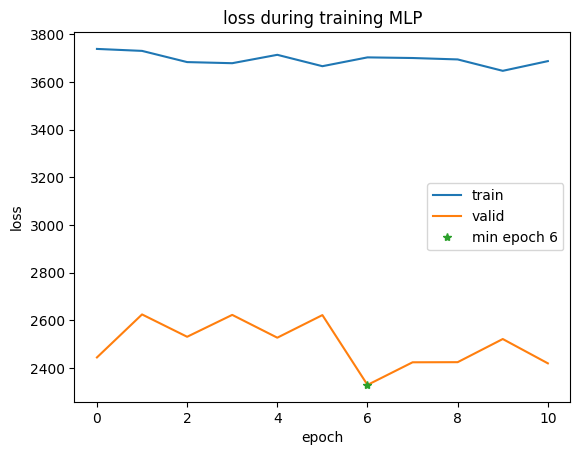

*************** diarrhoea ***************
TN: 3; FP: 6; FN: 28; TP: 44
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.580  &0.472  &0.880  &0.611  &0.333  &0.721 &0.500 &-0.036 &0.914

Epoch:11 [Train] Loss:3636.956 |  [Valid] Loss: 2725.785	EarlyStopping counter: 5 out of 30
Epoch:12 [Train] Loss:3687.506 |  [Valid] Loss: 2728.690	EarlyStopping counter: 6 out of 30
Epoch:13 [Train] Loss:3681.419 |  [Valid] Loss: 2624.338	EarlyStopping counter: 7 out of 30
Epoch:14 [Train] Loss:3675.952 |  [Valid] Loss: 2197.699	SAVE MODEL: loss drop: 2328.223 -> 2197.699
Epoch:15 [Train] Loss:3671.057 |  [Valid] Loss: 2518.722	EarlyStopping counter: 1 out of 30
Epoch:16 [Train] Loss:3671.520 |  [Valid] Loss: 2626.069	EarlyStopping counter: 2 out of 30
Epoch:17 [Train] Loss:3675.259 |  [Valid] Loss: 2629.832	EarlyStopping counter: 3 out of 30
Epoch:18 [Train] Loss:3667.300 |  [Valid] Loss: 2408.825	EarlyStopping counter: 4 out of 30
Epoch:19 [Train] Loss:3667.747 |  [Valid] Loss: 

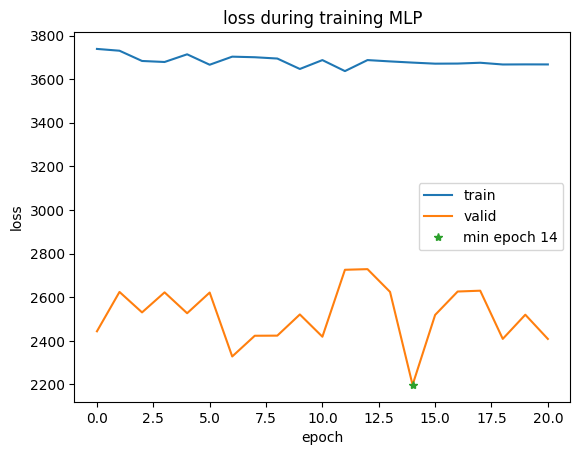

*************** diarrhoea ***************
TN: 1; FP: 8; FN: 6; TP: 66
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.827  &0.514  &0.892  &0.917  &0.111  &0.904 &0.498 &0.031 &0.913

Epoch:21 [Train] Loss:3660.931 |  [Valid] Loss: 2633.432	EarlyStopping counter: 7 out of 30
Epoch:22 [Train] Loss:3663.011 |  [Valid] Loss: 2407.024	EarlyStopping counter: 8 out of 30
Epoch:23 [Train] Loss:3657.254 |  [Valid] Loss: 2636.007	EarlyStopping counter: 9 out of 30
Epoch:24 [Train] Loss:3660.304 |  [Valid] Loss: 2756.509	EarlyStopping counter: 10 out of 30
Epoch:25 [Train] Loss:3657.644 |  [Valid] Loss: 2522.819	EarlyStopping counter: 11 out of 30
Epoch:26 [Train] Loss:3659.730 |  [Valid] Loss: 2522.510	EarlyStopping counter: 12 out of 30
Epoch:27 [Train] Loss:3656.896 |  [Valid] Loss: 2408.805	EarlyStopping counter: 13 out of 30
Epoch:28 [Train] Loss:3656.719 |  [Valid] Loss: 2404.146	EarlyStopping counter: 14 out of 30
Epoch:29 [Train] Loss:3658.394 |  [Valid] Loss: 2761.9

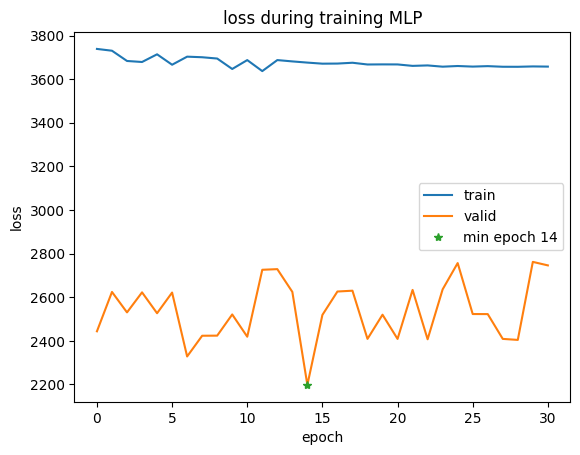

*************** diarrhoea ***************
TN: 0; FP: 9; FN: 1; TP: 71
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.877  &0.493  &0.887  &0.986  &0.000  &0.934 &0.497 &-0.040 &0.913

Epoch:31 [Train] Loss:3654.042 |  [Valid] Loss: 2639.157	EarlyStopping counter: 17 out of 30
Epoch:32 [Train] Loss:3658.184 |  [Valid] Loss: 2407.454	EarlyStopping counter: 18 out of 30
Epoch:33 [Train] Loss:3661.004 |  [Valid] Loss: 2288.168	EarlyStopping counter: 19 out of 30
Epoch:34 [Train] Loss:3651.898 |  [Valid] Loss: 2524.546	EarlyStopping counter: 20 out of 30
Epoch:35 [Train] Loss:3657.304 |  [Valid] Loss: 2521.637	EarlyStopping counter: 21 out of 30
Epoch:36 [Train] Loss:3651.523 |  [Valid] Loss: 2525.324	EarlyStopping counter: 22 out of 30
Epoch:37 [Train] Loss:3650.697 |  [Valid] Loss: 2524.837	EarlyStopping counter: 23 out of 30
Epoch:38 [Train] Loss:3646.490 |  [Valid] Loss: 2285.838	EarlyStopping counter: 24 out of 30
Epoch:39 [Train] Loss:3659.223 |  [Valid] Loss: 26

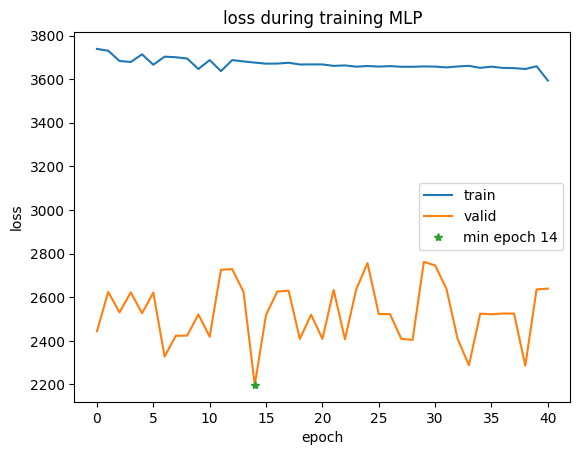

*************** diarrhoea ***************
TN: 0; FP: 9; FN: 0; TP: 72
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.889  &0.500  &0.889  &1.000  &0.000  &0.941 &0.498 &  nan &0.913

Epoch:41 [Train] Loss:3646.335 |  [Valid] Loss: 2524.738	EarlyStopping counter: 27 out of 30
Epoch:42 [Train] Loss:3654.015 |  [Valid] Loss: 2402.770	EarlyStopping counter: 28 out of 30
Epoch:43 [Train] Loss:3652.808 |  [Valid] Loss: 2526.861	EarlyStopping counter: 29 out of 30
Epoch:44 [Train] Loss:3648.937 |  [Valid] Loss: 2407.677	EarlyStopping counter: 30 out of 30
early stop
Finished training 



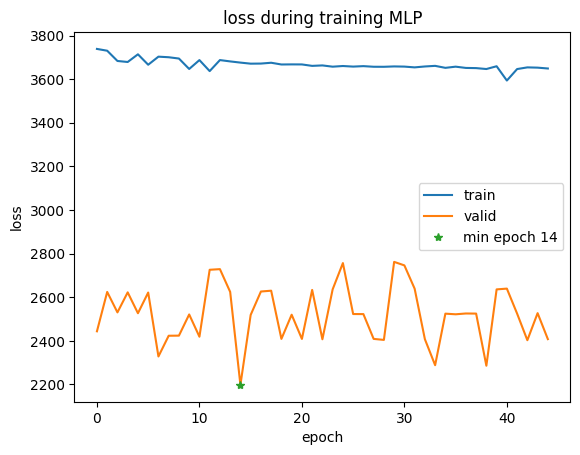

load model from path:  test.pt
*************** diarrhoea ***************
TN: 2; FP: 5; FN: 7; TP: 57
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.831  &0.588  &0.919  &0.891  &0.286  &0.905 &0.667 &0.158 &0.952


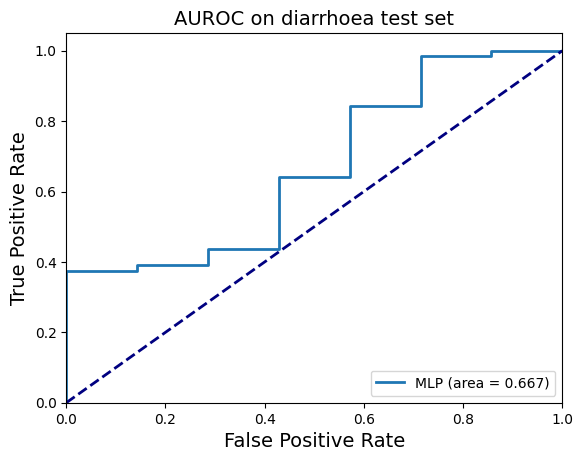

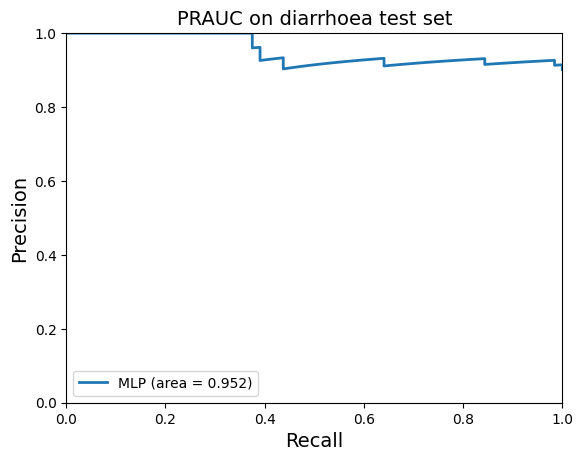


TN: 2; FP: 5; FN: 7; TP: 57
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.831  &0.588  &0.919  &0.891  &0.286  &0.905 &0.667 &0.158 &0.952
Fold 2
-------
Epoch:0 [Train] Loss:3978.815 |  [Valid] Loss: 2497.477	SAVE MODEL: loss drop: inf -> 2497.477
Epoch:1 [Train] Loss:3976.437 |  [Valid] Loss: 2496.319	SAVE MODEL: loss drop: 2497.477 -> 2496.319
Epoch:2 [Train] Loss:4025.958 |  [Valid] Loss: 2495.455	SAVE MODEL: loss drop: 2496.319 -> 2495.455
Epoch:3 [Train] Loss:4025.644 |  [Valid] Loss: 2381.195	SAVE MODEL: loss drop: 2495.455 -> 2381.195
Epoch:4 [Train] Loss:4024.173 |  [Valid] Loss: 2607.999	EarlyStopping counter: 1 out of 30
Epoch:5 [Train] Loss:4025.036 |  [Valid] Loss: 2379.739	SAVE MODEL: loss drop: 2381.195 -> 2379.739
Epoch:6 [Train] Loss:3973.086 |  [Valid] Loss: 2606.784	EarlyStopping counter: 1 out of 30
Epoch:7 [Train] Loss:4022.833 |  [Valid] Loss: 2606.965	EarlyStopping counter: 2 out of 30
Epoch:8 [Train] Loss:4021.896 |  [Valid] Loss: 2605.40

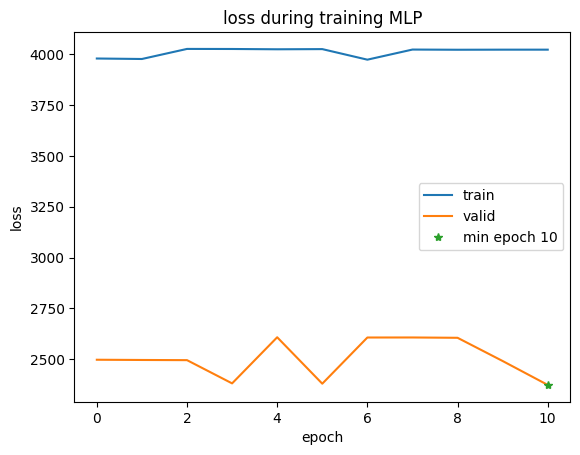

*************** diarrhoea ***************
TN: 6; FP: 1; FN: 33; TP: 41
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.580  &0.706  &0.976  &0.554  &0.857  &0.707 &0.774 &0.231 &0.976

Epoch:11 [Train] Loss:4019.696 |  [Valid] Loss: 2259.128	SAVE MODEL: loss drop: 2373.648 -> 2259.128
Epoch:12 [Train] Loss:4021.751 |  [Valid] Loss: 2257.893	SAVE MODEL: loss drop: 2259.128 -> 2257.893
Epoch:13 [Train] Loss:4020.652 |  [Valid] Loss: 2489.180	EarlyStopping counter: 1 out of 30
Epoch:14 [Train] Loss:4020.341 |  [Valid] Loss: 2372.432	EarlyStopping counter: 2 out of 30
Epoch:15 [Train] Loss:4018.477 |  [Valid] Loss: 2604.830	EarlyStopping counter: 3 out of 30
Epoch:16 [Train] Loss:4020.262 |  [Valid] Loss: 2253.088	SAVE MODEL: loss drop: 2257.893 -> 2253.088
Epoch:17 [Train] Loss:4016.429 |  [Valid] Loss: 2368.340	EarlyStopping counter: 1 out of 30
Epoch:18 [Train] Loss:4019.277 |  [Valid] Loss: 2247.513	SAVE MODEL: loss drop: 2253.088 -> 2247.513
Epoch:19 [Train] Loss:

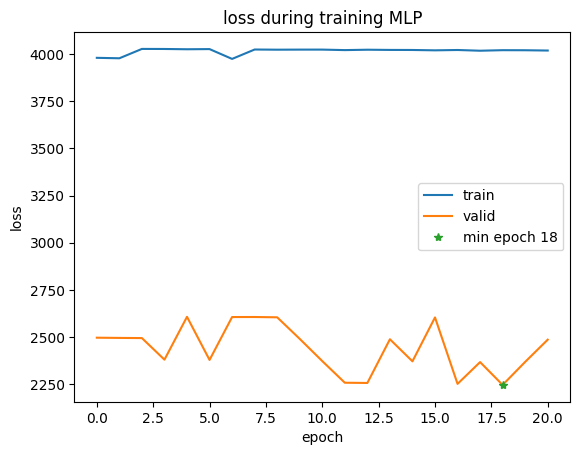

*************** diarrhoea ***************
TN: 4; FP: 3; FN: 19; TP: 55
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.728  &0.657  &0.948  &0.743  &0.571  &0.833 &0.759 &0.196 &0.975

Epoch:21 [Train] Loss:4018.270 |  [Valid] Loss: 2127.657	SAVE MODEL: loss drop: 2247.513 -> 2127.657
Epoch:22 [Train] Loss:4019.109 |  [Valid] Loss: 2486.406	EarlyStopping counter: 1 out of 30
Epoch:23 [Train] Loss:4016.322 |  [Valid] Loss: 2131.393	EarlyStopping counter: 2 out of 30
Epoch:24 [Train] Loss:4021.588 |  [Valid] Loss: 2365.790	EarlyStopping counter: 3 out of 30
Epoch:25 [Train] Loss:4022.705 |  [Valid] Loss: 2485.963	EarlyStopping counter: 4 out of 30
Epoch:26 [Train] Loss:4018.340 |  [Valid] Loss: 2246.349	EarlyStopping counter: 5 out of 30
Epoch:27 [Train] Loss:4019.256 |  [Valid] Loss: 2245.667	EarlyStopping counter: 6 out of 30
Epoch:28 [Train] Loss:4021.170 |  [Valid] Loss: 2485.464	EarlyStopping counter: 7 out of 30
Epoch:29 [Train] Loss:3965.077 |  [Valid] Loss: 2

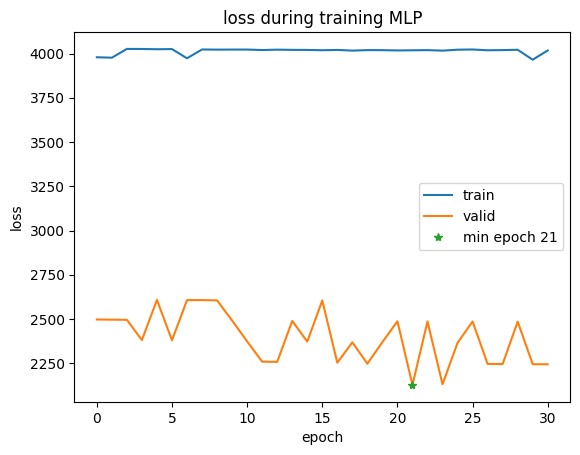

*************** diarrhoea ***************
TN: 1; FP: 6; FN: 9; TP: 65
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.815  &0.511  &0.915  &0.878  &0.143  &0.897 &0.755 &0.018 &0.975

Epoch:31 [Train] Loss:4016.766 |  [Valid] Loss: 2366.007	EarlyStopping counter: 10 out of 30
Epoch:32 [Train] Loss:4017.003 |  [Valid] Loss: 2243.295	EarlyStopping counter: 11 out of 30
Epoch:33 [Train] Loss:4016.086 |  [Valid] Loss: 2603.613	EarlyStopping counter: 12 out of 30
Epoch:34 [Train] Loss:3964.317 |  [Valid] Loss: 2484.851	EarlyStopping counter: 13 out of 30
Epoch:35 [Train] Loss:4016.160 |  [Valid] Loss: 2484.674	EarlyStopping counter: 14 out of 30
Epoch:36 [Train] Loss:4017.986 |  [Valid] Loss: 2363.127	EarlyStopping counter: 15 out of 30
Epoch:37 [Train] Loss:4016.010 |  [Valid] Loss: 2604.776	EarlyStopping counter: 16 out of 30
Epoch:38 [Train] Loss:4015.327 |  [Valid] Loss: 2483.727	EarlyStopping counter: 17 out of 30
Epoch:39 [Train] Loss:4016.264 |  [Valid] Loss: 224

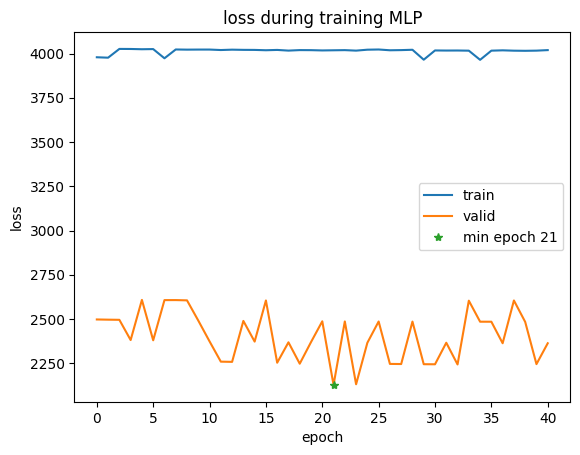

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 3; TP: 71
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.877  &0.480  &0.910  &0.959  &0.000  &0.934 &0.749 &-0.060 &0.974

Epoch:41 [Train] Loss:4015.337 |  [Valid] Loss: 2363.456	EarlyStopping counter: 20 out of 30
Epoch:42 [Train] Loss:4015.794 |  [Valid] Loss: 2361.502	EarlyStopping counter: 21 out of 30
Epoch:43 [Train] Loss:4016.411 |  [Valid] Loss: 2603.720	EarlyStopping counter: 22 out of 30
Epoch:44 [Train] Loss:4016.582 |  [Valid] Loss: 2483.413	EarlyStopping counter: 23 out of 30
Epoch:45 [Train] Loss:3961.212 |  [Valid] Loss: 2482.885	EarlyStopping counter: 24 out of 30
Epoch:46 [Train] Loss:4016.587 |  [Valid] Loss: 2482.899	EarlyStopping counter: 25 out of 30
Epoch:47 [Train] Loss:4017.336 |  [Valid] Loss: 2360.834	EarlyStopping counter: 26 out of 30
Epoch:48 [Train] Loss:3959.611 |  [Valid] Loss: 2482.853	EarlyStopping counter: 27 out of 30
Epoch:49 [Train] Loss:4016.815 |  [Valid] Loss: 24

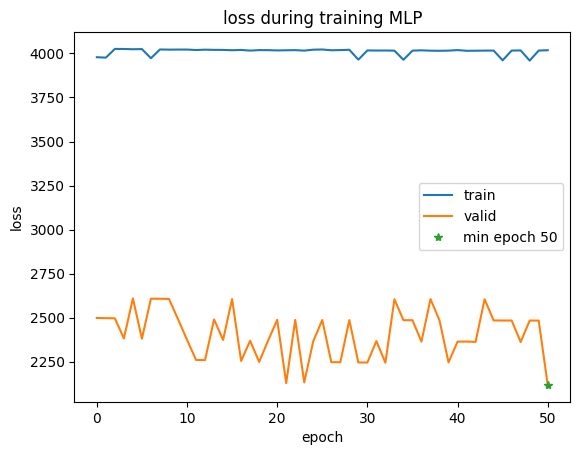

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 74
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.914  &0.500  &0.914  &1.000  &0.000  &0.955 &0.741 &  nan &0.973

Epoch:51 [Train] Loss:4010.673 |  [Valid] Loss: 2604.204	EarlyStopping counter: 1 out of 30
Epoch:52 [Train] Loss:3961.234 |  [Valid] Loss: 2603.864	EarlyStopping counter: 2 out of 30
Epoch:53 [Train] Loss:4016.149 |  [Valid] Loss: 2603.700	EarlyStopping counter: 3 out of 30
Epoch:54 [Train] Loss:4018.017 |  [Valid] Loss: 2235.821	EarlyStopping counter: 4 out of 30
Epoch:55 [Train] Loss:3961.685 |  [Valid] Loss: 2359.845	EarlyStopping counter: 5 out of 30
Epoch:56 [Train] Loss:4015.946 |  [Valid] Loss: 2603.914	EarlyStopping counter: 6 out of 30
Epoch:57 [Train] Loss:4015.305 |  [Valid] Loss: 2481.708	EarlyStopping counter: 7 out of 30
Epoch:58 [Train] Loss:4014.656 |  [Valid] Loss: 2236.892	EarlyStopping counter: 8 out of 30
Epoch:59 [Train] Loss:3964.799 |  [Valid] Loss: 2602.859	Ea

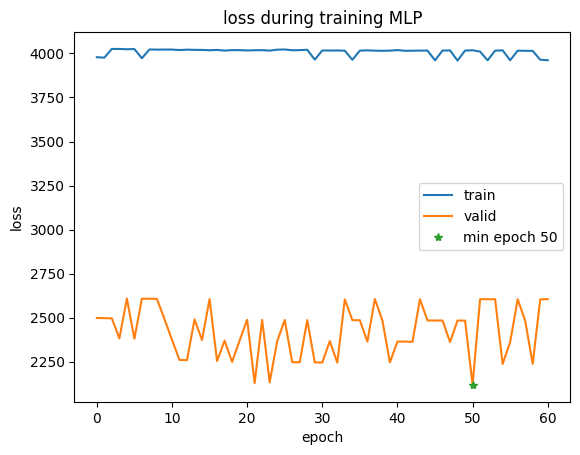

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 74
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.914  &0.500  &0.914  &1.000  &0.000  &0.955 &0.728 &  nan &0.971

Epoch:61 [Train] Loss:4015.065 |  [Valid] Loss: 2481.375	EarlyStopping counter: 11 out of 30
Epoch:62 [Train] Loss:4012.142 |  [Valid] Loss: 2604.248	EarlyStopping counter: 12 out of 30
Epoch:63 [Train] Loss:4015.727 |  [Valid] Loss: 2481.133	EarlyStopping counter: 13 out of 30
Epoch:64 [Train] Loss:4019.084 |  [Valid] Loss: 2481.318	EarlyStopping counter: 14 out of 30
Epoch:65 [Train] Loss:4015.191 |  [Valid] Loss: 2359.226	EarlyStopping counter: 15 out of 30
Epoch:66 [Train] Loss:4014.407 |  [Valid] Loss: 2481.426	EarlyStopping counter: 16 out of 30
Epoch:67 [Train] Loss:4014.514 |  [Valid] Loss: 2481.369	EarlyStopping counter: 17 out of 30
Epoch:68 [Train] Loss:3962.388 |  [Valid] Loss: 2603.940	EarlyStopping counter: 18 out of 30
Epoch:69 [Train] Loss:4016.008 |  [Valid] Loss: 235

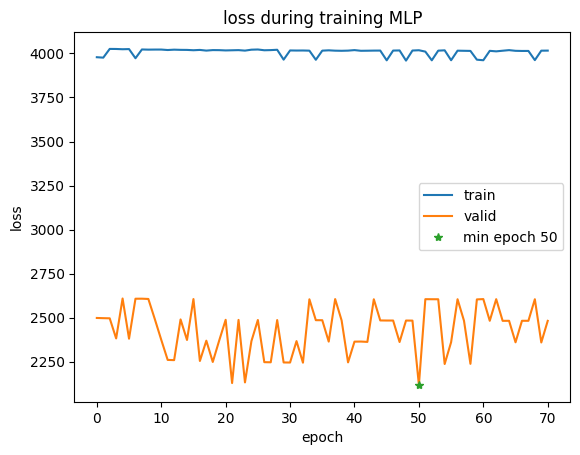

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 74
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.914  &0.500  &0.914  &1.000  &0.000  &0.955 &0.716 &  nan &0.968

Epoch:71 [Train] Loss:4015.530 |  [Valid] Loss: 2480.991	EarlyStopping counter: 21 out of 30
Epoch:72 [Train] Loss:3960.165 |  [Valid] Loss: 2235.100	EarlyStopping counter: 22 out of 30
Epoch:73 [Train] Loss:4012.402 |  [Valid] Loss: 2234.425	EarlyStopping counter: 23 out of 30
Epoch:74 [Train] Loss:4013.944 |  [Valid] Loss: 2604.159	EarlyStopping counter: 24 out of 30
Epoch:75 [Train] Loss:4015.524 |  [Valid] Loss: 2480.184	EarlyStopping counter: 25 out of 30
Epoch:76 [Train] Loss:4013.471 |  [Valid] Loss: 2480.668	EarlyStopping counter: 26 out of 30
Epoch:77 [Train] Loss:4013.555 |  [Valid] Loss: 2601.804	EarlyStopping counter: 27 out of 30
Epoch:78 [Train] Loss:4014.571 |  [Valid] Loss: 2603.101	EarlyStopping counter: 28 out of 30
Epoch:79 [Train] Loss:4014.496 |  [Valid] Loss: 235

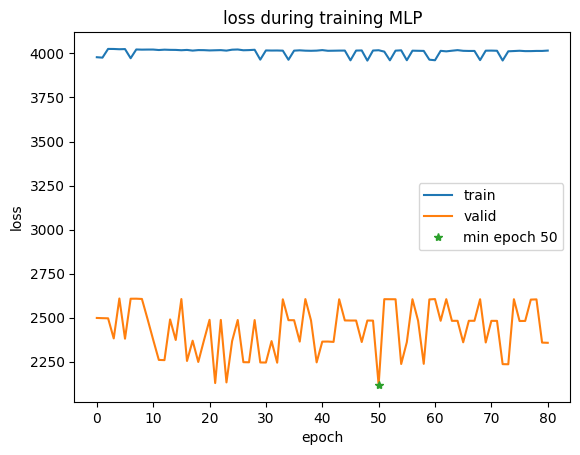

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 74
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.914  &0.500  &0.914  &1.000  &0.000  &0.955 &0.732 &  nan &0.971

early stop
Finished training 



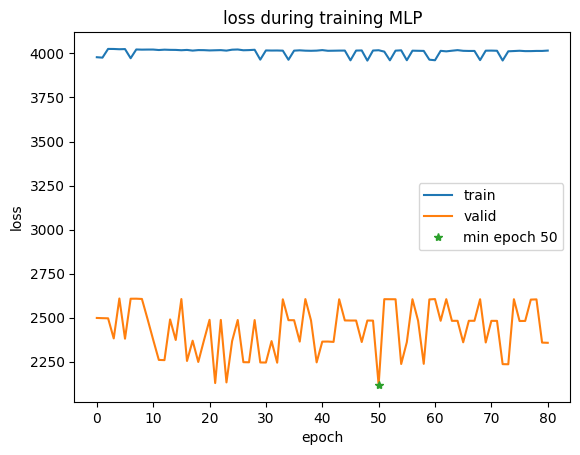

load model from path:  test.pt
*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 64
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.901  &0.500  &0.901  &1.000  &0.000  &0.948 &0.681 &  nan &0.952


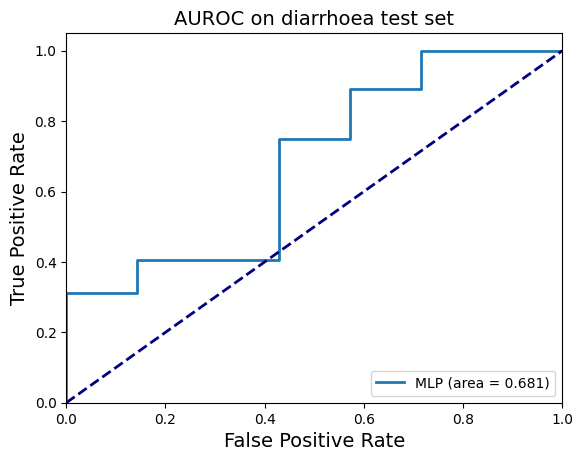

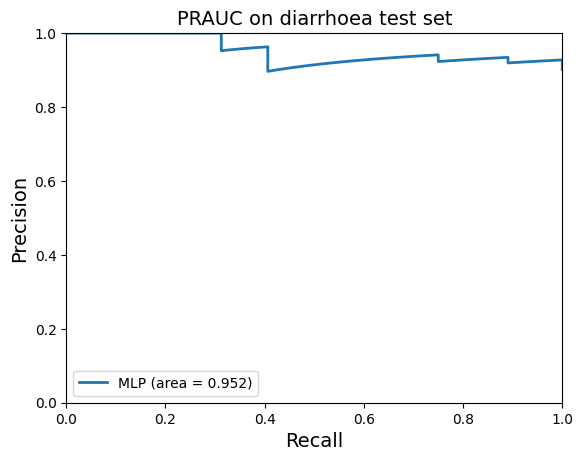


TN: 0; FP: 7; FN: 0; TP: 64
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.901  &0.500  &0.901  &1.000  &0.000  &0.948 &0.681 &  nan &0.952
Fold 3
-------
Epoch:0 [Train] Loss:3964.818 |  [Valid] Loss: 2393.357	SAVE MODEL: loss drop: inf -> 2393.357
Epoch:1 [Train] Loss:3964.112 |  [Valid] Loss: 2512.371	EarlyStopping counter: 1 out of 30
Epoch:2 [Train] Loss:3962.504 |  [Valid] Loss: 2754.145	EarlyStopping counter: 2 out of 30
Epoch:3 [Train] Loss:3962.118 |  [Valid] Loss: 2632.882	EarlyStopping counter: 3 out of 30
Epoch:4 [Train] Loss:3962.574 |  [Valid] Loss: 2510.425	EarlyStopping counter: 4 out of 30
Epoch:5 [Train] Loss:3960.758 |  [Valid] Loss: 2756.174	EarlyStopping counter: 5 out of 30
Epoch:6 [Train] Loss:3959.783 |  [Valid] Loss: 2756.933	EarlyStopping counter: 6 out of 30
Epoch:7 [Train] Loss:3907.268 |  [Valid] Loss: 2633.136	EarlyStopping counter: 7 out of 30
Epoch:8 [Train] Loss:3959.185 |  [Valid] Loss: 2633.407	EarlyStopping counter: 8 out of 30

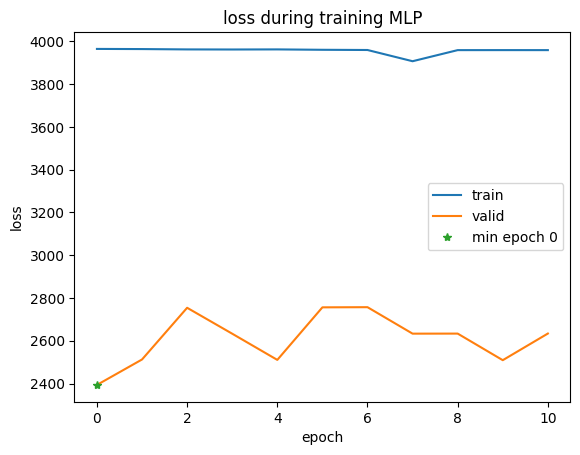

*************** diarrhoea ***************
TN: 0; FP: 8; FN: 0; TP: 72
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.900  &0.500  &0.900  &1.000  &0.000  &0.947 &0.531 &  nan &0.908

Epoch:11 [Train] Loss:3957.132 |  [Valid] Loss: 2758.926	EarlyStopping counter: 11 out of 30
Epoch:12 [Train] Loss:3959.198 |  [Valid] Loss: 2757.105	EarlyStopping counter: 12 out of 30
Epoch:13 [Train] Loss:3959.255 |  [Valid] Loss: 2633.964	EarlyStopping counter: 13 out of 30
Epoch:14 [Train] Loss:3958.069 |  [Valid] Loss: 2507.744	EarlyStopping counter: 14 out of 30
Epoch:15 [Train] Loss:3957.501 |  [Valid] Loss: 2634.331	EarlyStopping counter: 15 out of 30
Epoch:16 [Train] Loss:3958.161 |  [Valid] Loss: 2380.375	SAVE MODEL: loss drop: 2393.357 -> 2380.375
Epoch:17 [Train] Loss:3903.053 |  [Valid] Loss: 2507.597	EarlyStopping counter: 1 out of 30
Epoch:18 [Train] Loss:3957.114 |  [Valid] Loss: 2761.357	EarlyStopping counter: 2 out of 30
Epoch:19 [Train] Loss:3902.178 |  [Valid] Los

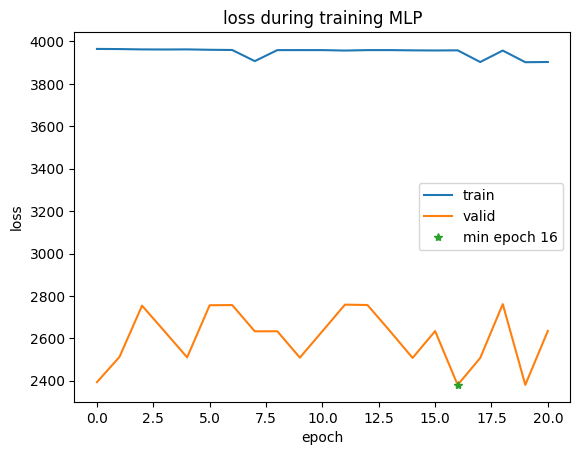

*************** diarrhoea ***************
TN: 0; FP: 8; FN: 0; TP: 72
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.900  &0.500  &0.900  &1.000  &0.000  &0.947 &0.488 &  nan &0.897

Epoch:21 [Train] Loss:3956.925 |  [Valid] Loss: 2635.916	EarlyStopping counter: 5 out of 30
Epoch:22 [Train] Loss:3957.807 |  [Valid] Loss: 2635.093	EarlyStopping counter: 6 out of 30
Epoch:23 [Train] Loss:3955.883 |  [Valid] Loss: 2635.376	EarlyStopping counter: 7 out of 30
Epoch:24 [Train] Loss:3902.861 |  [Valid] Loss: 2379.123	SAVE MODEL: loss drop: 2380.375 -> 2379.123
Epoch:25 [Train] Loss:3957.658 |  [Valid] Loss: 2506.852	EarlyStopping counter: 1 out of 30
Epoch:26 [Train] Loss:3956.015 |  [Valid] Loss: 2377.466	SAVE MODEL: loss drop: 2379.123 -> 2377.466
Epoch:27 [Train] Loss:3955.870 |  [Valid] Loss: 2636.215	EarlyStopping counter: 1 out of 30
Epoch:28 [Train] Loss:3900.784 |  [Valid] Loss: 2636.704	EarlyStopping counter: 2 out of 30
Epoch:29 [Train] Loss:3955.974 |  [Valid]

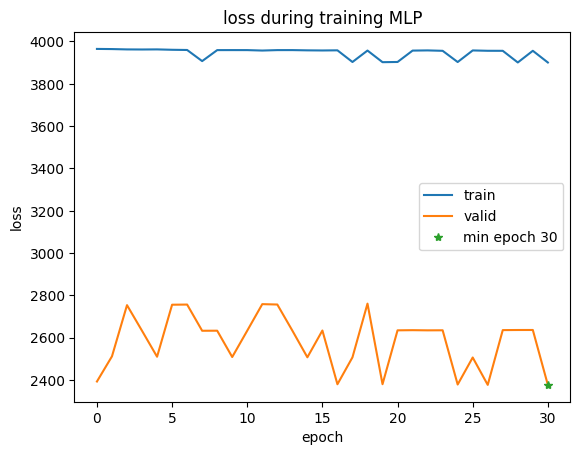

*************** diarrhoea ***************
TN: 0; FP: 8; FN: 0; TP: 72
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.900  &0.500  &0.900  &1.000  &0.000  &0.947 &0.484 &  nan &0.896

Epoch:31 [Train] Loss:3955.941 |  [Valid] Loss: 2377.327	EarlyStopping counter: 1 out of 30
Epoch:32 [Train] Loss:3955.884 |  [Valid] Loss: 2506.690	EarlyStopping counter: 2 out of 30
Epoch:33 [Train] Loss:3955.497 |  [Valid] Loss: 2376.707	SAVE MODEL: loss drop: 2377.224 -> 2376.707
Epoch:34 [Train] Loss:3957.546 |  [Valid] Loss: 2506.767	EarlyStopping counter: 1 out of 30
Epoch:35 [Train] Loss:3957.789 |  [Valid] Loss: 2766.745	EarlyStopping counter: 2 out of 30
Epoch:36 [Train] Loss:3954.769 |  [Valid] Loss: 2636.358	EarlyStopping counter: 3 out of 30
Epoch:37 [Train] Loss:3954.616 |  [Valid] Loss: 2764.668	EarlyStopping counter: 4 out of 30
Epoch:38 [Train] Loss:3954.426 |  [Valid] Loss: 2506.112	EarlyStopping counter: 5 out of 30
Epoch:39 [Train] Loss:3956.049 |  [Valid] Loss: 25

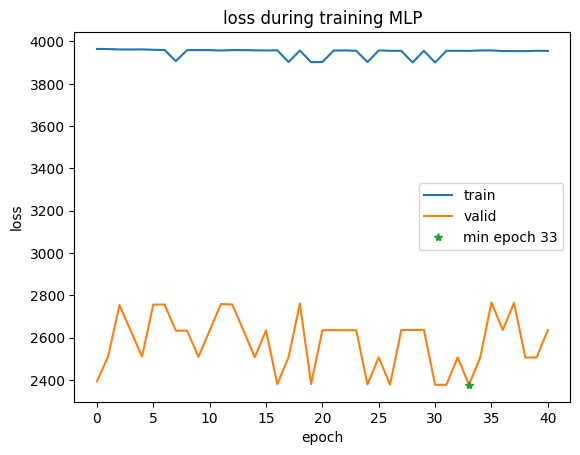

*************** diarrhoea ***************
TN: 0; FP: 8; FN: 0; TP: 72
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.900  &0.500  &0.900  &1.000  &0.000  &0.947 &0.479 &  nan &0.888

Epoch:41 [Train] Loss:3954.625 |  [Valid] Loss: 2375.417	SAVE MODEL: loss drop: 2376.707 -> 2375.417
Epoch:42 [Train] Loss:3954.008 |  [Valid] Loss: 2637.503	EarlyStopping counter: 1 out of 30
Epoch:43 [Train] Loss:3953.995 |  [Valid] Loss: 2637.228	EarlyStopping counter: 2 out of 30
Epoch:44 [Train] Loss:3957.737 |  [Valid] Loss: 2637.969	EarlyStopping counter: 3 out of 30
Epoch:45 [Train] Loss:3956.241 |  [Valid] Loss: 2506.442	EarlyStopping counter: 4 out of 30
Epoch:46 [Train] Loss:3956.064 |  [Valid] Loss: 2767.001	EarlyStopping counter: 5 out of 30
Epoch:47 [Train] Loss:3956.321 |  [Valid] Loss: 2637.822	EarlyStopping counter: 6 out of 30
Epoch:48 [Train] Loss:3956.606 |  [Valid] Loss: 2637.708	EarlyStopping counter: 7 out of 30
Epoch:49 [Train] Loss:3954.600 |  [Valid] Loss: 25

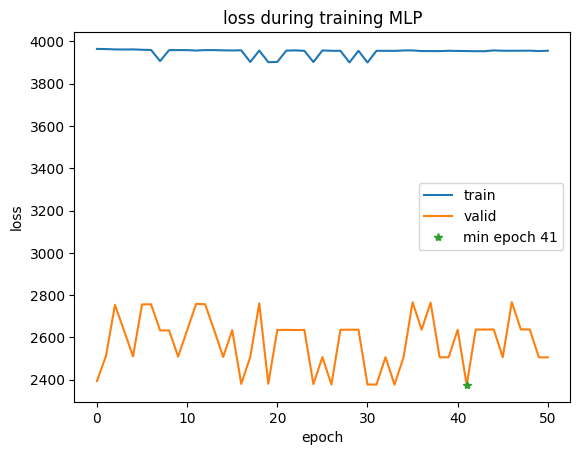

*************** diarrhoea ***************
TN: 0; FP: 8; FN: 0; TP: 72
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.900  &0.500  &0.900  &1.000  &0.000  &0.947 &0.472 &  nan &0.887

Epoch:51 [Train] Loss:3898.595 |  [Valid] Loss: 2637.135	EarlyStopping counter: 10 out of 30
Epoch:52 [Train] Loss:3955.972 |  [Valid] Loss: 2767.941	EarlyStopping counter: 11 out of 30
Epoch:53 [Train] Loss:3955.213 |  [Valid] Loss: 2637.179	EarlyStopping counter: 12 out of 30
Epoch:54 [Train] Loss:3956.413 |  [Valid] Loss: 2506.197	EarlyStopping counter: 13 out of 30
Epoch:55 [Train] Loss:3955.284 |  [Valid] Loss: 2637.557	EarlyStopping counter: 14 out of 30
Epoch:56 [Train] Loss:3898.405 |  [Valid] Loss: 2506.368	EarlyStopping counter: 15 out of 30
Epoch:57 [Train] Loss:3897.738 |  [Valid] Loss: 2506.187	EarlyStopping counter: 16 out of 30
Epoch:58 [Train] Loss:3956.312 |  [Valid] Loss: 2637.905	EarlyStopping counter: 17 out of 30
Epoch:59 [Train] Loss:3955.583 |  [Valid] Loss: 237

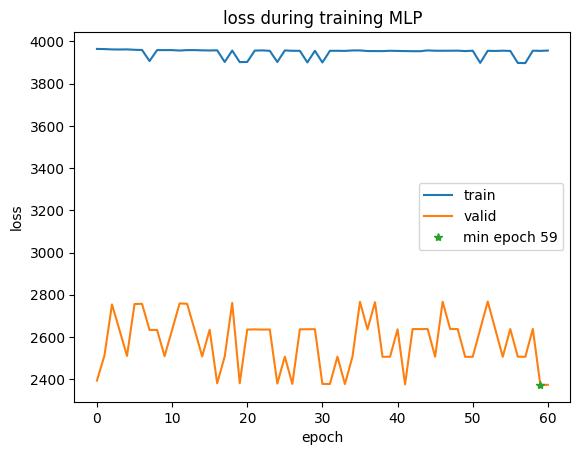

*************** diarrhoea ***************
TN: 0; FP: 8; FN: 0; TP: 72
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.900  &0.500  &0.900  &1.000  &0.000  &0.947 &0.465 &  nan &0.885

Epoch:61 [Train] Loss:3898.550 |  [Valid] Loss: 2505.898	EarlyStopping counter: 2 out of 30
Epoch:62 [Train] Loss:3955.089 |  [Valid] Loss: 2767.559	EarlyStopping counter: 3 out of 30
Epoch:63 [Train] Loss:3896.787 |  [Valid] Loss: 2768.931	EarlyStopping counter: 4 out of 30
Epoch:64 [Train] Loss:3955.210 |  [Valid] Loss: 2242.670	SAVE MODEL: loss drop: 2372.803 -> 2242.670
Epoch:65 [Train] Loss:3896.787 |  [Valid] Loss: 2637.705	EarlyStopping counter: 1 out of 30
Epoch:66 [Train] Loss:3955.614 |  [Valid] Loss: 2638.775	EarlyStopping counter: 2 out of 30
Epoch:67 [Train] Loss:3955.954 |  [Valid] Loss: 2770.733	EarlyStopping counter: 3 out of 30
Epoch:68 [Train] Loss:3955.861 |  [Valid] Loss: 2638.573	EarlyStopping counter: 4 out of 30
Epoch:69 [Train] Loss:3898.828 |  [Valid] Loss: 26

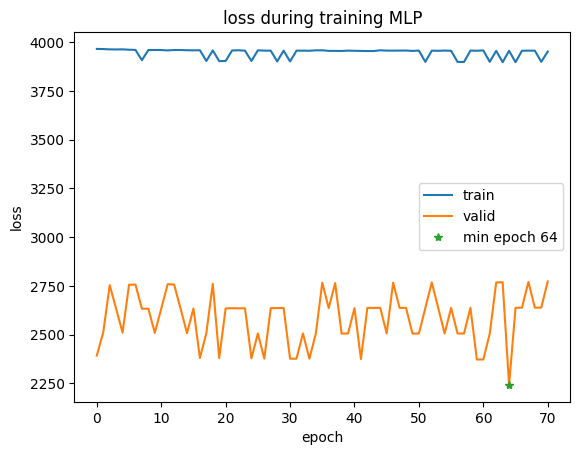

*************** diarrhoea ***************
TN: 0; FP: 8; FN: 0; TP: 72
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.900  &0.500  &0.900  &1.000  &0.000  &0.947 &0.467 &  nan &0.896

Epoch:71 [Train] Loss:3955.948 |  [Valid] Loss: 2638.347	EarlyStopping counter: 7 out of 30
Epoch:72 [Train] Loss:3953.431 |  [Valid] Loss: 2506.024	EarlyStopping counter: 8 out of 30
Epoch:73 [Train] Loss:3898.909 |  [Valid] Loss: 2638.627	EarlyStopping counter: 9 out of 30
Epoch:74 [Train] Loss:3958.068 |  [Valid] Loss: 2638.184	EarlyStopping counter: 10 out of 30
Epoch:75 [Train] Loss:3955.901 |  [Valid] Loss: 2638.144	EarlyStopping counter: 11 out of 30
Epoch:76 [Train] Loss:3954.674 |  [Valid] Loss: 2770.254	EarlyStopping counter: 12 out of 30
Epoch:77 [Train] Loss:3955.311 |  [Valid] Loss: 2373.116	EarlyStopping counter: 13 out of 30
Epoch:78 [Train] Loss:3955.491 |  [Valid] Loss: 2374.110	EarlyStopping counter: 14 out of 30
Epoch:79 [Train] Loss:3897.750 |  [Valid] Loss: 2505.6

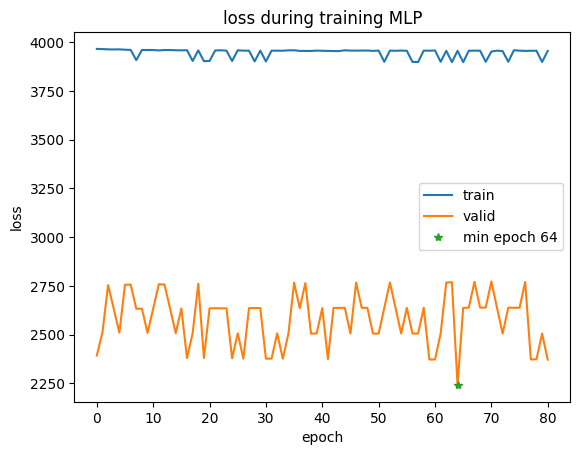

*************** diarrhoea ***************
TN: 0; FP: 8; FN: 0; TP: 72
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.900  &0.500  &0.900  &1.000  &0.000  &0.947 &0.465 &  nan &0.895

Epoch:81 [Train] Loss:3953.927 |  [Valid] Loss: 2506.034	EarlyStopping counter: 17 out of 30
Epoch:82 [Train] Loss:3955.185 |  [Valid] Loss: 2373.959	EarlyStopping counter: 18 out of 30
Epoch:83 [Train] Loss:3955.639 |  [Valid] Loss: 2638.103	EarlyStopping counter: 19 out of 30
Epoch:84 [Train] Loss:3953.742 |  [Valid] Loss: 2637.825	EarlyStopping counter: 20 out of 30
Epoch:85 [Train] Loss:3954.400 |  [Valid] Loss: 2638.155	EarlyStopping counter: 21 out of 30
Epoch:86 [Train] Loss:3954.212 |  [Valid] Loss: 2505.906	EarlyStopping counter: 22 out of 30
Epoch:87 [Train] Loss:3954.035 |  [Valid] Loss: 2772.199	EarlyStopping counter: 23 out of 30
Epoch:88 [Train] Loss:3957.220 |  [Valid] Loss: 2769.274	EarlyStopping counter: 24 out of 30
Epoch:89 [Train] Loss:3955.203 |  [Valid] Loss: 250

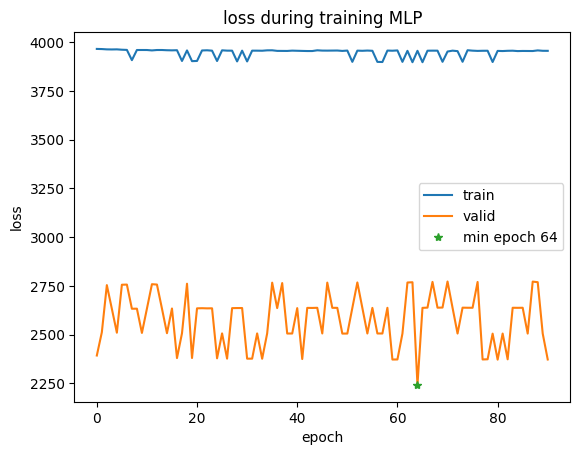

*************** diarrhoea ***************
TN: 0; FP: 8; FN: 0; TP: 72
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.900  &0.500  &0.900  &1.000  &0.000  &0.947 &0.448 &  nan &0.886

Epoch:91 [Train] Loss:3954.387 |  [Valid] Loss: 2505.686	EarlyStopping counter: 27 out of 30
Epoch:92 [Train] Loss:3954.763 |  [Valid] Loss: 2637.669	EarlyStopping counter: 28 out of 30
Epoch:93 [Train] Loss:3898.361 |  [Valid] Loss: 2505.640	EarlyStopping counter: 29 out of 30
Epoch:94 [Train] Loss:3954.470 |  [Valid] Loss: 2505.669	EarlyStopping counter: 30 out of 30
early stop
Finished training 



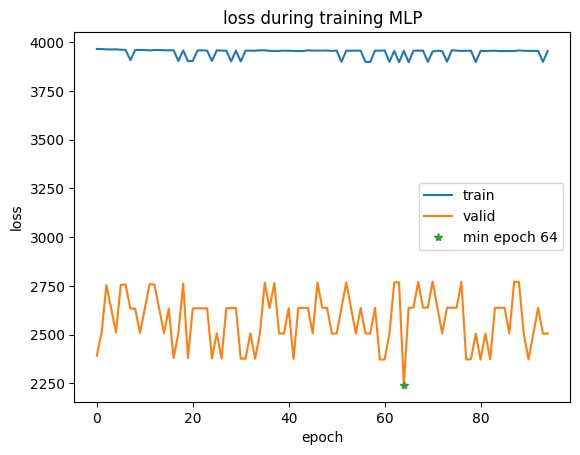

load model from path:  test.pt
*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 64
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.901  &0.500  &0.901  &1.000  &0.000  &0.948 &0.629 &  nan &0.939


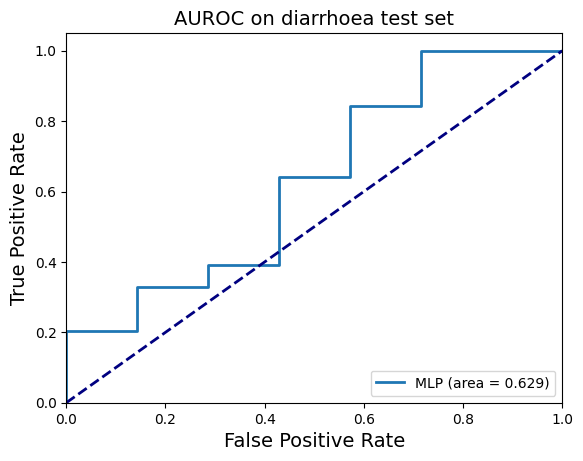

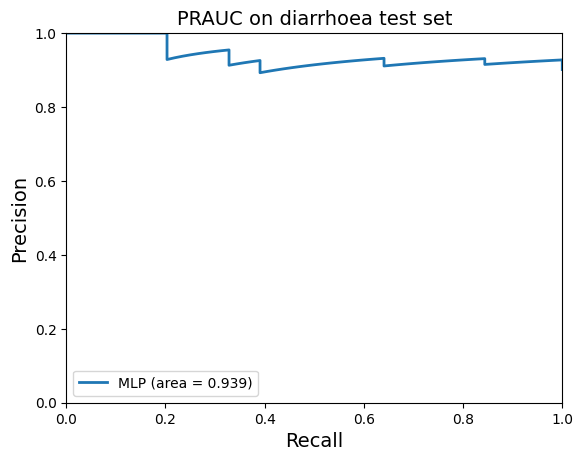


TN: 0; FP: 7; FN: 0; TP: 64
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.901  &0.500  &0.901  &1.000  &0.000  &0.948 &0.629 &  nan &0.939
Fold 4
-------
Epoch:0 [Train] Loss:3720.681 |  [Valid] Loss: 2428.144	SAVE MODEL: loss drop: inf -> 2428.144
Epoch:1 [Train] Loss:3763.791 |  [Valid] Loss: 2320.255	SAVE MODEL: loss drop: 2428.144 -> 2320.255
Epoch:2 [Train] Loss:3762.263 |  [Valid] Loss: 2319.247	SAVE MODEL: loss drop: 2320.255 -> 2319.247
Epoch:3 [Train] Loss:3760.541 |  [Valid] Loss: 2426.681	EarlyStopping counter: 1 out of 30
Epoch:4 [Train] Loss:3760.446 |  [Valid] Loss: 2208.813	SAVE MODEL: loss drop: 2319.247 -> 2208.813
Epoch:5 [Train] Loss:3760.045 |  [Valid] Loss: 2207.238	SAVE MODEL: loss drop: 2208.813 -> 2207.238
Epoch:6 [Train] Loss:3758.702 |  [Valid] Loss: 2097.349	SAVE MODEL: loss drop: 2207.238 -> 2097.349
Epoch:7 [Train] Loss:3757.901 |  [Valid] Loss: 2203.778	EarlyStopping counter: 1 out of 30
Epoch:8 [Train] Loss:3708.220 |  [Valid] Loss

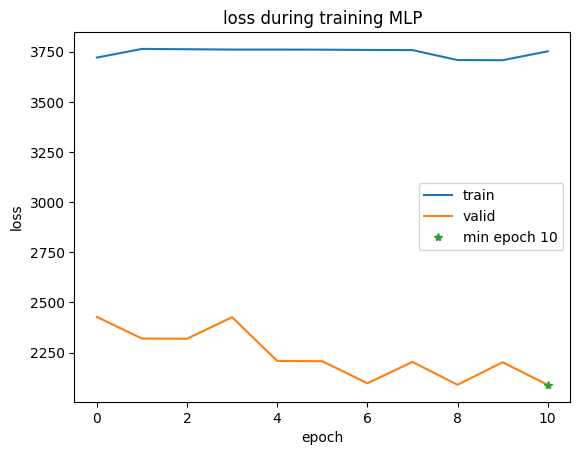

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 73
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.912  &0.500  &0.912  &1.000  &0.000  &0.954 &0.507 &  nan &0.928

Epoch:11 [Train] Loss:3754.104 |  [Valid] Loss: 2311.185	EarlyStopping counter: 1 out of 30
Epoch:12 [Train] Loss:3754.283 |  [Valid] Loss: 2310.559	EarlyStopping counter: 2 out of 30
Epoch:13 [Train] Loss:3703.452 |  [Valid] Loss: 2083.629	SAVE MODEL: loss drop: 2089.098 -> 2083.629
Epoch:14 [Train] Loss:3752.958 |  [Valid] Loss: 2197.516	EarlyStopping counter: 1 out of 30
Epoch:15 [Train] Loss:3701.692 |  [Valid] Loss: 2195.032	EarlyStopping counter: 2 out of 30
Epoch:16 [Train] Loss:3752.453 |  [Valid] Loss: 2422.036	EarlyStopping counter: 3 out of 30
Epoch:17 [Train] Loss:3750.340 |  [Valid] Loss: 2307.954	EarlyStopping counter: 4 out of 30
Epoch:18 [Train] Loss:3752.918 |  [Valid] Loss: 2307.612	EarlyStopping counter: 5 out of 30
Epoch:19 [Train] Loss:3751.227 |  [Valid] Loss: 21

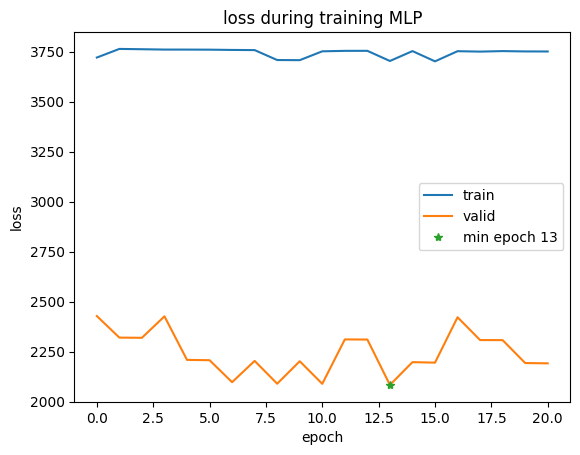

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 73
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.912  &0.500  &0.912  &1.000  &0.000  &0.954 &0.511 &  nan &0.929

Epoch:21 [Train] Loss:3749.409 |  [Valid] Loss: 2189.029	EarlyStopping counter: 8 out of 30
Epoch:22 [Train] Loss:3750.801 |  [Valid] Loss: 2191.045	EarlyStopping counter: 9 out of 30
Epoch:23 [Train] Loss:3697.110 |  [Valid] Loss: 2189.829	EarlyStopping counter: 10 out of 30
Epoch:24 [Train] Loss:3697.241 |  [Valid] Loss: 2305.808	EarlyStopping counter: 11 out of 30
Epoch:25 [Train] Loss:3752.537 |  [Valid] Loss: 2188.870	EarlyStopping counter: 12 out of 30
Epoch:26 [Train] Loss:3646.423 |  [Valid] Loss: 2305.279	EarlyStopping counter: 13 out of 30
Epoch:27 [Train] Loss:3751.009 |  [Valid] Loss: 2304.957	EarlyStopping counter: 14 out of 30
Epoch:28 [Train] Loss:3697.760 |  [Valid] Loss: 2304.549	EarlyStopping counter: 15 out of 30
Epoch:29 [Train] Loss:3749.713 |  [Valid] Loss: 2187.

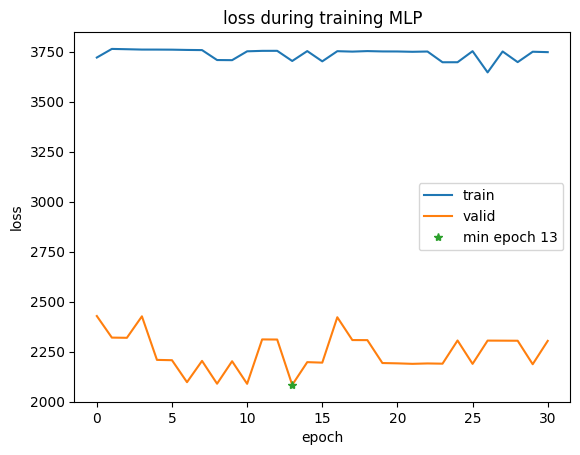

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 73
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.912  &0.500  &0.912  &1.000  &0.000  &0.954 &0.513 &  nan &0.929

Epoch:31 [Train] Loss:3697.655 |  [Valid] Loss: 2303.714	EarlyStopping counter: 18 out of 30
Epoch:32 [Train] Loss:3748.480 |  [Valid] Loss: 2303.763	EarlyStopping counter: 19 out of 30
Epoch:33 [Train] Loss:3747.629 |  [Valid] Loss: 2303.401	EarlyStopping counter: 20 out of 30
Epoch:34 [Train] Loss:3697.485 |  [Valid] Loss: 2418.553	EarlyStopping counter: 21 out of 30
Epoch:35 [Train] Loss:3743.630 |  [Valid] Loss: 2067.657	SAVE MODEL: loss drop: 2083.629 -> 2067.657
Epoch:36 [Train] Loss:3748.907 |  [Valid] Loss: 2303.320	EarlyStopping counter: 1 out of 30
Epoch:37 [Train] Loss:3748.778 |  [Valid] Loss: 2184.443	EarlyStopping counter: 2 out of 30
Epoch:38 [Train] Loss:3699.269 |  [Valid] Loss: 2420.817	EarlyStopping counter: 3 out of 30
Epoch:39 [Train] Loss:3749.045 |  [Valid] Loss

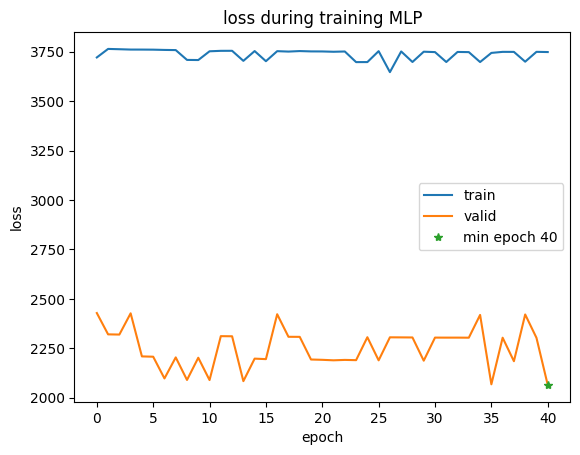

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 73
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.912  &0.500  &0.912  &1.000  &0.000  &0.954 &0.526 &  nan &0.932

Epoch:41 [Train] Loss:3696.753 |  [Valid] Loss: 2183.780	EarlyStopping counter: 1 out of 30
Epoch:42 [Train] Loss:3750.299 |  [Valid] Loss: 2302.392	EarlyStopping counter: 2 out of 30
Epoch:43 [Train] Loss:3750.500 |  [Valid] Loss: 2302.488	EarlyStopping counter: 3 out of 30
Epoch:44 [Train] Loss:3748.879 |  [Valid] Loss: 2302.609	EarlyStopping counter: 4 out of 30
Epoch:45 [Train] Loss:3748.429 |  [Valid] Loss: 1949.468	SAVE MODEL: loss drop: 2064.560 -> 1949.468
Epoch:46 [Train] Loss:3748.376 |  [Valid] Loss: 2302.185	EarlyStopping counter: 1 out of 30
Epoch:47 [Train] Loss:3746.736 |  [Valid] Loss: 2302.275	EarlyStopping counter: 2 out of 30
Epoch:48 [Train] Loss:3745.047 |  [Valid] Loss: 2183.978	EarlyStopping counter: 3 out of 30
Epoch:49 [Train] Loss:3644.191 |  [Valid] Loss: 23

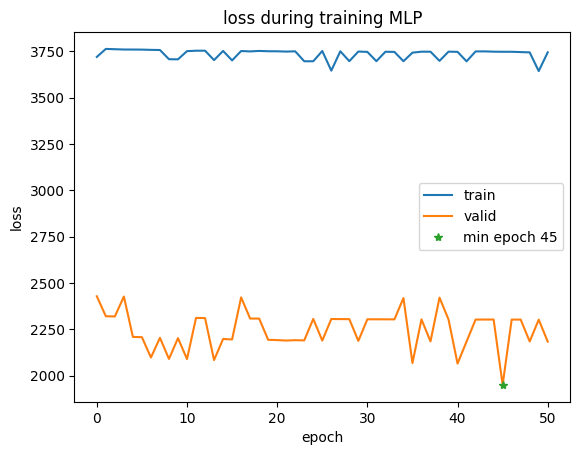

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 73
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.912  &0.500  &0.912  &1.000  &0.000  &0.954 &0.540 &  nan &0.936

Epoch:51 [Train] Loss:3746.656 |  [Valid] Loss: 2420.281	EarlyStopping counter: 6 out of 30
Epoch:52 [Train] Loss:3693.457 |  [Valid] Loss: 2062.376	EarlyStopping counter: 7 out of 30
Epoch:53 [Train] Loss:3694.935 |  [Valid] Loss: 2181.810	EarlyStopping counter: 8 out of 30
Epoch:54 [Train] Loss:3747.509 |  [Valid] Loss: 2181.665	EarlyStopping counter: 9 out of 30
Epoch:55 [Train] Loss:3747.377 |  [Valid] Loss: 2419.947	EarlyStopping counter: 10 out of 30
Epoch:56 [Train] Loss:3747.468 |  [Valid] Loss: 2301.153	EarlyStopping counter: 11 out of 30
Epoch:57 [Train] Loss:3745.907 |  [Valid] Loss: 2063.871	EarlyStopping counter: 12 out of 30
Epoch:58 [Train] Loss:3746.351 |  [Valid] Loss: 2300.739	EarlyStopping counter: 13 out of 30
Epoch:59 [Train] Loss:3746.226 |  [Valid] Loss: 2300.85

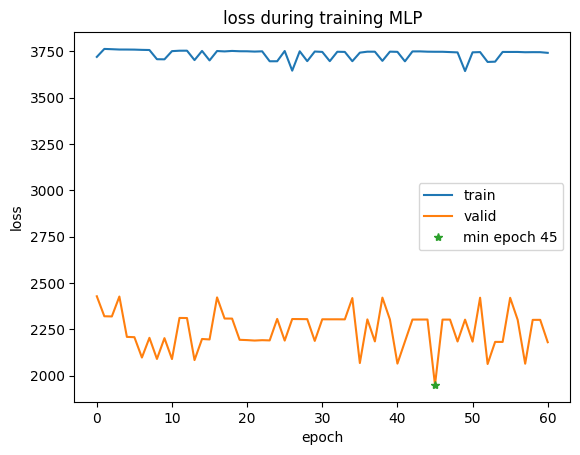

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 73
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.912  &0.500  &0.912  &1.000  &0.000  &0.954 &0.564 &  nan &0.941

Epoch:61 [Train] Loss:3747.165 |  [Valid] Loss: 2058.751	EarlyStopping counter: 16 out of 30
Epoch:62 [Train] Loss:3747.735 |  [Valid] Loss: 2181.293	EarlyStopping counter: 17 out of 30
Epoch:63 [Train] Loss:3698.271 |  [Valid] Loss: 2419.360	EarlyStopping counter: 18 out of 30
Epoch:64 [Train] Loss:3746.610 |  [Valid] Loss: 2061.397	EarlyStopping counter: 19 out of 30
Epoch:65 [Train] Loss:3693.914 |  [Valid] Loss: 2300.587	EarlyStopping counter: 20 out of 30
Epoch:66 [Train] Loss:3694.863 |  [Valid] Loss: 2300.624	EarlyStopping counter: 21 out of 30
Epoch:67 [Train] Loss:3745.619 |  [Valid] Loss: 2300.315	EarlyStopping counter: 22 out of 30
Epoch:68 [Train] Loss:3745.894 |  [Valid] Loss: 2420.718	EarlyStopping counter: 23 out of 30
Epoch:69 [Train] Loss:3746.442 |  [Valid] Loss: 230

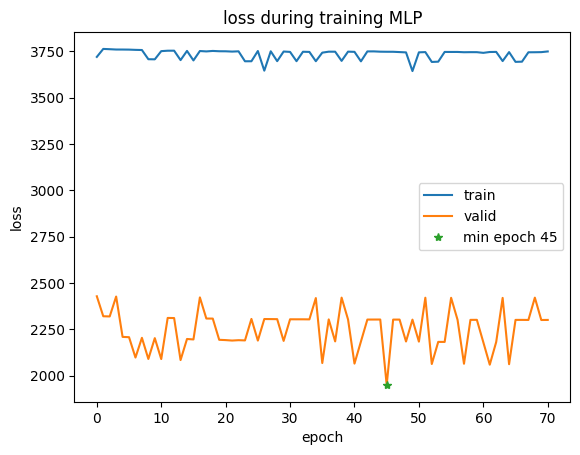

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 73
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.912  &0.500  &0.912  &1.000  &0.000  &0.954 &0.573 &  nan &0.944

Epoch:71 [Train] Loss:3747.713 |  [Valid] Loss: 2300.461	EarlyStopping counter: 26 out of 30
Epoch:72 [Train] Loss:3745.183 |  [Valid] Loss: 2300.207	EarlyStopping counter: 27 out of 30
Epoch:73 [Train] Loss:3747.237 |  [Valid] Loss: 2180.087	EarlyStopping counter: 28 out of 30
Epoch:74 [Train] Loss:3745.903 |  [Valid] Loss: 1939.796	SAVE MODEL: loss drop: 1949.468 -> 1939.796
Epoch:75 [Train] Loss:3745.965 |  [Valid] Loss: 2300.275	EarlyStopping counter: 1 out of 30
Epoch:76 [Train] Loss:3745.157 |  [Valid] Loss: 2180.810	EarlyStopping counter: 2 out of 30
Epoch:77 [Train] Loss:3693.283 |  [Valid] Loss: 1938.224	SAVE MODEL: loss drop: 1939.796 -> 1938.224
Epoch:78 [Train] Loss:3747.967 |  [Valid] Loss: 2058.118	EarlyStopping counter: 1 out of 30
Epoch:79 [Train] Loss:3693.571 |  [Val

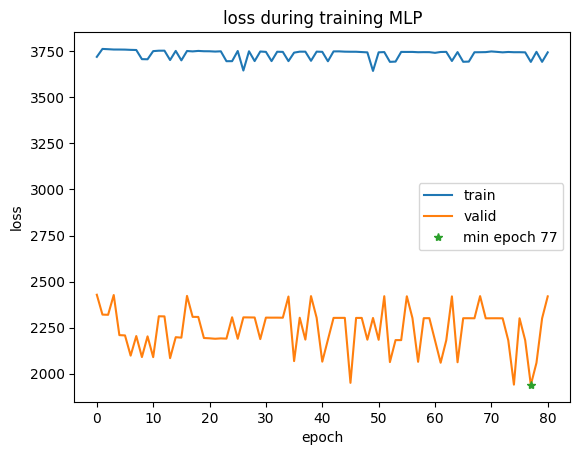

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 73
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.912  &0.500  &0.912  &1.000  &0.000  &0.954 &0.575 &  nan &0.943

Epoch:81 [Train] Loss:3693.265 |  [Valid] Loss: 2299.699	EarlyStopping counter: 4 out of 30
Epoch:82 [Train] Loss:3746.530 |  [Valid] Loss: 2299.535	EarlyStopping counter: 5 out of 30
Epoch:83 [Train] Loss:3746.758 |  [Valid] Loss: 2178.687	EarlyStopping counter: 6 out of 30
Epoch:84 [Train] Loss:3749.403 |  [Valid] Loss: 2299.610	EarlyStopping counter: 7 out of 30
Epoch:85 [Train] Loss:3746.818 |  [Valid] Loss: 2178.407	EarlyStopping counter: 8 out of 30
Epoch:86 [Train] Loss:3694.786 |  [Valid] Loss: 2299.434	EarlyStopping counter: 9 out of 30
Epoch:87 [Train] Loss:3693.363 |  [Valid] Loss: 2056.794	EarlyStopping counter: 10 out of 30
Epoch:88 [Train] Loss:3745.948 |  [Valid] Loss: 2299.304	EarlyStopping counter: 11 out of 30
Epoch:89 [Train] Loss:3748.000 |  [Valid] Loss: 2058.757	

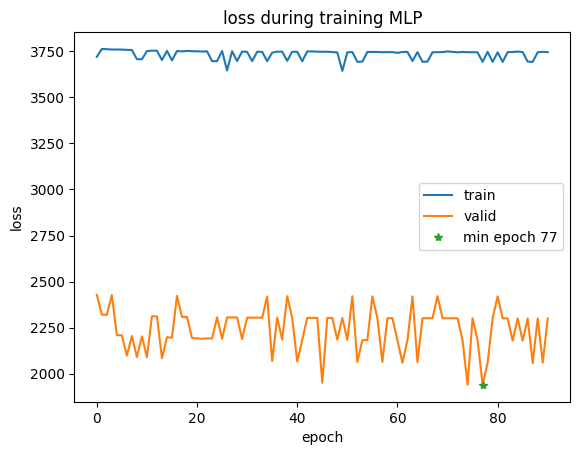

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 73
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.912  &0.500  &0.912  &1.000  &0.000  &0.954 &0.573 &  nan &0.941

Epoch:91 [Train] Loss:3747.011 |  [Valid] Loss: 2299.554	EarlyStopping counter: 14 out of 30
Epoch:92 [Train] Loss:3747.128 |  [Valid] Loss: 2179.218	EarlyStopping counter: 15 out of 30
Epoch:93 [Train] Loss:3744.869 |  [Valid] Loss: 2299.578	EarlyStopping counter: 16 out of 30
Epoch:94 [Train] Loss:3695.338 |  [Valid] Loss: 2179.103	EarlyStopping counter: 17 out of 30
Epoch:95 [Train] Loss:3744.474 |  [Valid] Loss: 2178.743	EarlyStopping counter: 18 out of 30
Epoch:96 [Train] Loss:3696.064 |  [Valid] Loss: 2299.239	EarlyStopping counter: 19 out of 30
Epoch:97 [Train] Loss:3745.623 |  [Valid] Loss: 2420.314	EarlyStopping counter: 20 out of 30
Epoch:98 [Train] Loss:3744.282 |  [Valid] Loss: 2177.716	EarlyStopping counter: 21 out of 30
Epoch:99 [Train] Loss:3744.509 |  [Valid] Loss: 229

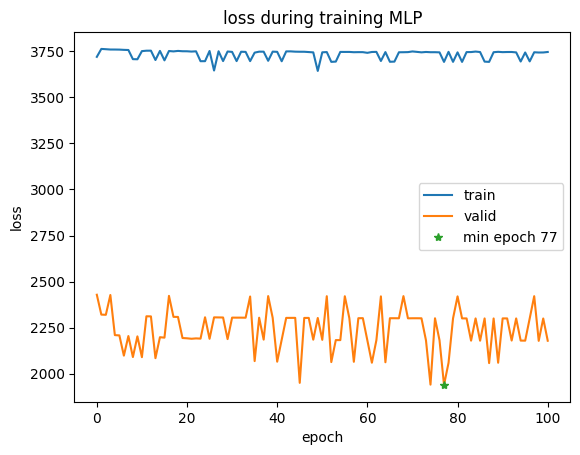

*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 73
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.912  &0.500  &0.912  &1.000  &0.000  &0.954 &0.571 &  nan &0.939

Epoch:101 [Train] Loss:3744.269 |  [Valid] Loss: 2179.696	EarlyStopping counter: 24 out of 30
Epoch:102 [Train] Loss:3692.586 |  [Valid] Loss: 2299.398	EarlyStopping counter: 25 out of 30
Epoch:103 [Train] Loss:3744.969 |  [Valid] Loss: 2178.677	EarlyStopping counter: 26 out of 30
Epoch:104 [Train] Loss:3743.030 |  [Valid] Loss: 2299.000	EarlyStopping counter: 27 out of 30
Epoch:105 [Train] Loss:3748.227 |  [Valid] Loss: 2298.983	EarlyStopping counter: 28 out of 30
Epoch:106 [Train] Loss:3745.915 |  [Valid] Loss: 2299.005	EarlyStopping counter: 29 out of 30
Epoch:107 [Train] Loss:3741.857 |  [Valid] Loss: 2178.313	EarlyStopping counter: 30 out of 30
early stop
Finished training 



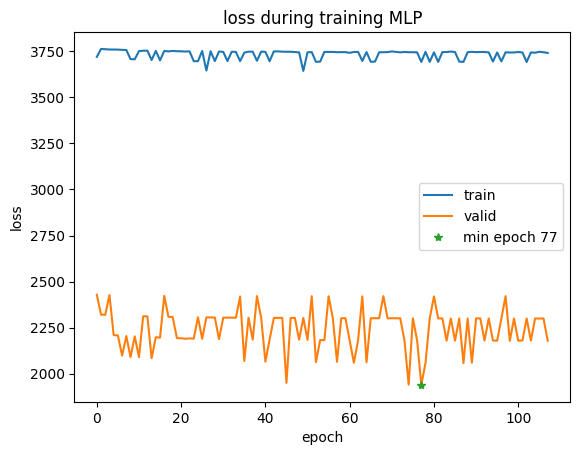

load model from path:  test.pt
*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 64
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.901  &0.500  &0.901  &1.000  &0.000  &0.948 &0.656 &  nan &0.949


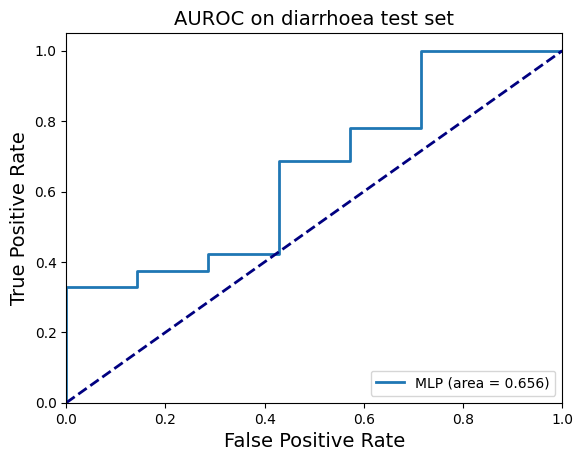

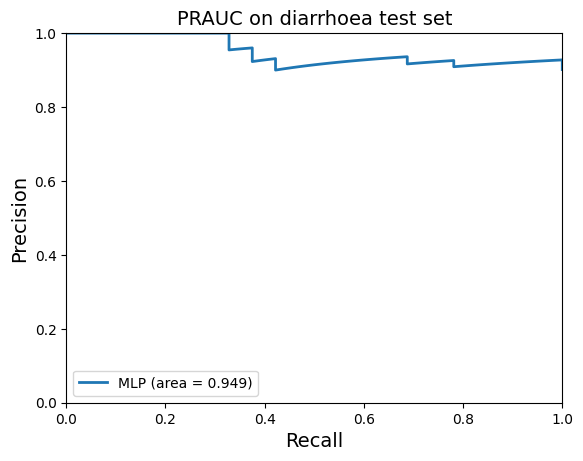


TN: 0; FP: 7; FN: 0; TP: 64
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.901  &0.500  &0.901  &1.000  &0.000  &0.948 &0.656 &  nan &0.949
Fold 5
-------
Epoch:0 [Train] Loss:3495.370 |  [Valid] Loss: 2045.665	SAVE MODEL: loss drop: inf -> 2045.665
Epoch:1 [Train] Loss:3452.959 |  [Valid] Loss: 1954.147	SAVE MODEL: loss drop: 2045.665 -> 1954.147
Epoch:2 [Train] Loss:3447.121 |  [Valid] Loss: 2298.471	EarlyStopping counter: 1 out of 30
Epoch:3 [Train] Loss:3441.302 |  [Valid] Loss: 2207.789	EarlyStopping counter: 2 out of 30
Epoch:4 [Train] Loss:3474.276 |  [Valid] Loss: 2383.962	EarlyStopping counter: 3 out of 30
Epoch:5 [Train] Loss:3432.976 |  [Valid] Loss: 2202.566	EarlyStopping counter: 4 out of 30
Epoch:6 [Train] Loss:3427.272 |  [Valid] Loss: 2290.633	EarlyStopping counter: 5 out of 30
Epoch:7 [Train] Loss:3462.467 |  [Valid] Loss: 2008.034	EarlyStopping counter: 6 out of 30
Epoch:8 [Train] Loss:3460.232 |  [Valid] Loss: 2287.373	EarlyStopping counter: 7 

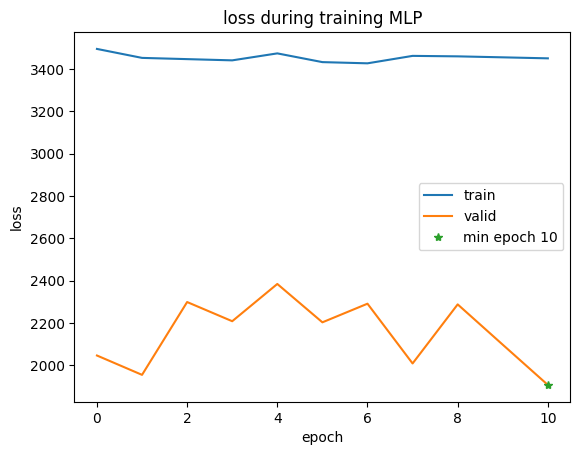

*************** diarrhoea ***************
TN: 0; FP: 8; FN: 0; TP: 72
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.900  &0.500  &0.900  &1.000  &0.000  &0.947 &0.535 &  nan &0.894

Epoch:11 [Train] Loss:3449.987 |  [Valid] Loss: 2283.376	EarlyStopping counter: 1 out of 30
Epoch:12 [Train] Loss:3450.172 |  [Valid] Loss: 2184.807	EarlyStopping counter: 2 out of 30
Epoch:13 [Train] Loss:3445.647 |  [Valid] Loss: 2375.920	EarlyStopping counter: 3 out of 30
Epoch:14 [Train] Loss:3441.890 |  [Valid] Loss: 2087.609	EarlyStopping counter: 4 out of 30
Epoch:15 [Train] Loss:3437.195 |  [Valid] Loss: 2182.738	EarlyStopping counter: 5 out of 30
Epoch:16 [Train] Loss:3389.924 |  [Valid] Loss: 2381.595	EarlyStopping counter: 6 out of 30
Epoch:17 [Train] Loss:3436.587 |  [Valid] Loss: 1983.712	EarlyStopping counter: 7 out of 30
Epoch:18 [Train] Loss:3423.057 |  [Valid] Loss: 2077.809	EarlyStopping counter: 8 out of 30
Epoch:19 [Train] Loss:3432.294 |  [Valid] Loss: 2175.686	Ea

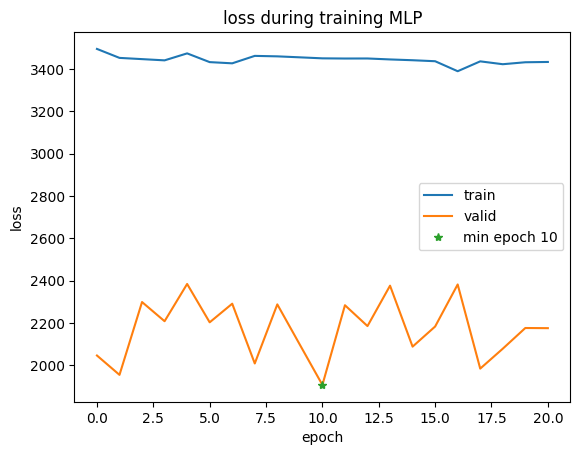

*************** diarrhoea ***************
TN: 0; FP: 8; FN: 0; TP: 72
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.900  &0.500  &0.900  &1.000  &0.000  &0.947 &0.530 &  nan &0.893

Epoch:21 [Train] Loss:3437.171 |  [Valid] Loss: 2278.568	EarlyStopping counter: 11 out of 30
Epoch:22 [Train] Loss:3384.355 |  [Valid] Loss: 2381.059	EarlyStopping counter: 12 out of 30
Epoch:23 [Train] Loss:3379.880 |  [Valid] Loss: 2171.583	EarlyStopping counter: 13 out of 30
Epoch:24 [Train] Loss:3380.250 |  [Valid] Loss: 2278.612	EarlyStopping counter: 14 out of 30
Epoch:25 [Train] Loss:3427.667 |  [Valid] Loss: 2279.087	EarlyStopping counter: 15 out of 30
Epoch:26 [Train] Loss:3429.480 |  [Valid] Loss: 2171.034	EarlyStopping counter: 16 out of 30
Epoch:27 [Train] Loss:3424.316 |  [Valid] Loss: 2277.903	EarlyStopping counter: 17 out of 30
Epoch:28 [Train] Loss:3423.396 |  [Valid] Loss: 2279.981	EarlyStopping counter: 18 out of 30
Epoch:29 [Train] Loss:3421.862 |  [Valid] Loss: 206

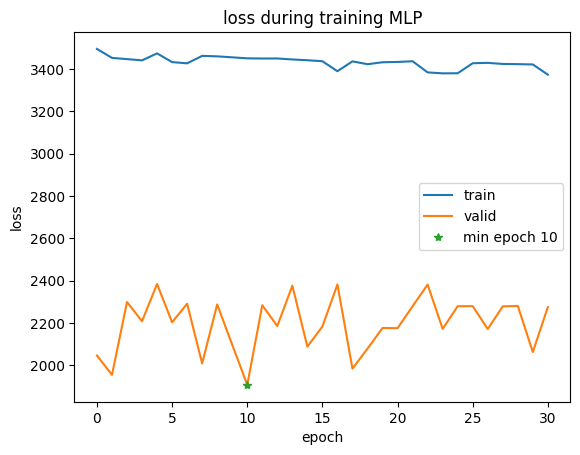

*************** diarrhoea ***************
TN: 0; FP: 8; FN: 0; TP: 72
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.900  &0.500  &0.900  &1.000  &0.000  &0.947 &0.526 &  nan &0.890

Epoch:31 [Train] Loss:3423.578 |  [Valid] Loss: 2281.283	EarlyStopping counter: 21 out of 30
Epoch:32 [Train] Loss:3416.759 |  [Valid] Loss: 2058.842	EarlyStopping counter: 22 out of 30
Epoch:33 [Train] Loss:3416.878 |  [Valid] Loss: 2169.926	EarlyStopping counter: 23 out of 30
Epoch:34 [Train] Loss:3421.703 |  [Valid] Loss: 2391.061	EarlyStopping counter: 24 out of 30
Epoch:35 [Train] Loss:3373.867 |  [Valid] Loss: 2276.743	EarlyStopping counter: 25 out of 30
Epoch:36 [Train] Loss:3414.368 |  [Valid] Loss: 2168.422	EarlyStopping counter: 26 out of 30
Epoch:37 [Train] Loss:3416.959 |  [Valid] Loss: 2167.836	EarlyStopping counter: 27 out of 30
Epoch:38 [Train] Loss:3422.205 |  [Valid] Loss: 2391.694	EarlyStopping counter: 28 out of 30
Epoch:39 [Train] Loss:3414.140 |  [Valid] Loss: 228

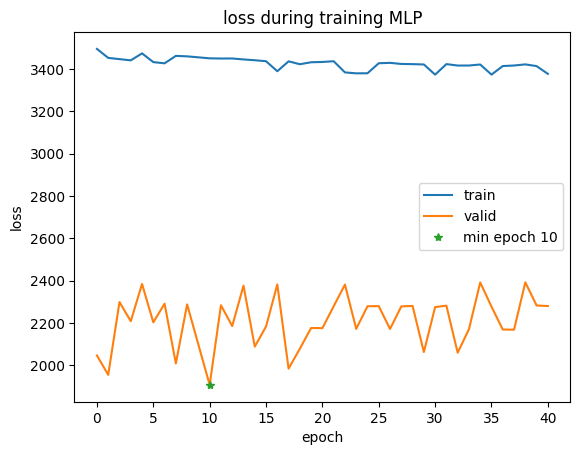

*************** diarrhoea ***************
TN: 0; FP: 8; FN: 0; TP: 72
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.900  &0.500  &0.900  &1.000  &0.000  &0.947 &0.524 &  nan &0.889

early stop
Finished training 



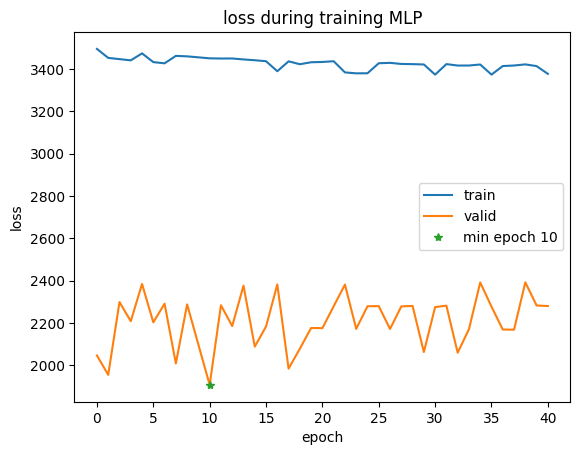

load model from path:  test.pt
*************** diarrhoea ***************
TN: 0; FP: 7; FN: 0; TP: 64
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.901  &0.500  &0.901  &1.000  &0.000  &0.948 &0.748 &  nan &0.967


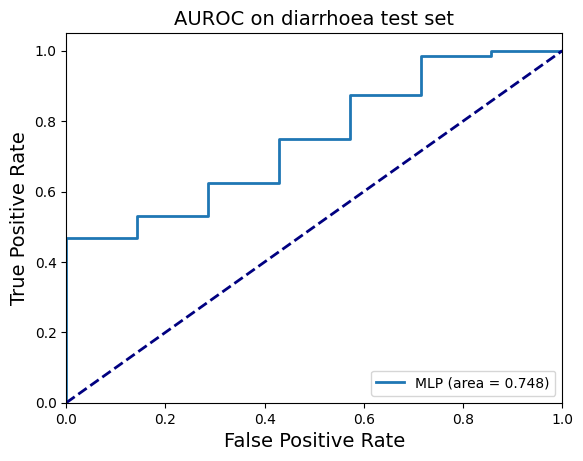

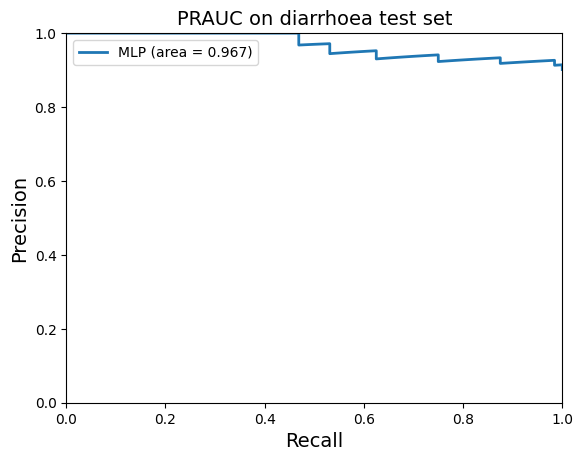


TN: 0; FP: 7; FN: 0; TP: 64
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.901  &0.500  &0.901  &1.000  &0.000  &0.948 &0.748 &  nan &0.967


In [13]:
"modify weight_loss: list, the higher the num, more penalize if predict label 0 wrong"
from sklearn.model_selection import KFold

k_folds = 5

kf = KFold(n_splits=k_folds, shuffle=True)

train_dataset = tox_dataset(train_df)
test_loader = DataLoader(tox_dataset(test_df), **params)

weight_losses = [7.0, 8.0, 8.0, 7.0, 6.0]

results = {
    "acc": [],
    "precision": [],
    "recall": [],
    "F1": [],
}
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")

    stopper = EarlyStopping(mode='lower', patience=patience)
    train_loader = DataLoader(
        train_dataset,
        batch_size=64,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    val_loader = DataLoader(
        train_dataset,
        batch_size=64,
        sampler=torch.utils.data.SubsetRandomSampler(val_idx),
    )

    model = Classifier(in_dim, h_dims)
    if torch.cuda.is_available(): model = model.cuda()
    optimizer = optim.AdamW(params=model.parameters(), lr=lr, weight_decay=wd)

    train(model, train_loader, val_loader, weight_loss=weight_losses[fold])
    _, probs, label = eval(model, test_loader, model_path)
    preds = get_preds(0.5, probs)
    cls_results = evaluate(label, preds, probs)
    # [ACCURACY, weighted_accuracy, precision, SE, SP, F1, AUC, MCC, AP]
    results["acc"].append(cls_results[0])
    results["precision"].append(cls_results[2])
    results["recall"].append(cls_results[3])
    results["F1"].append(cls_results[5])

results["acc"].append(np.mean(results["acc"]))
results["precision"].append(np.mean(results["precision"]))
results["recall"].append(np.mean(results["recall"]))
results["F1"].append(np.mean(results["F1"]))

results_df = pd.DataFrame.from_dict(results)
results_df.to_csv(f"{ae_name}_results.csv", index=False)
